# Поиск по изображениям
## Постановка задачи
Заказчик проекта - фотохостинг для профессиональных фотографов «Со Смыслом» (“With Sense”). 

Пользователи сервиса размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. 

Данный проект - часть эксперимента по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Например, такое: `A man is crossing a mountain pass on a metal bridge`.

Сервис выводит несколько фотографий с такой же или похожей сценой.

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Результатом проекта должна стать демонстрационная версия поиска изображений по запросу.

Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 

На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.

##Юридические ограничения
В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

При попытке посмотреть изображения, запрещённые законодательством, на сервисе вместо картинок показывается дисклеймер:
`This image is unavailable in your country in compliance with local laws`.

Однако в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер. 


## Импорт библиотек
Импортируем библиотеки, необходимые для работы.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 29 08:26:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
#зафиксируем версии библиотек
!pip install -q pandas==1.5.3
!pip install -q numpy==1.22.4
!pip install -q matplotlib==3.7.1
!pip install -q tensorflow==2.12.0
!pip install -q keras==2.12.0
#!pip3 install -q cv2==4.7.0
!pip3 install -q opencv-python
#!pip install -q cv2==4.7.0
!pip install -q transformers==4.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.6 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential,Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
# from keras.layers.advanced_activations import LeakyReLU
from keras.layers import LeakyReLU
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import norm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupShuffleSplit
import cv2
from collections import Counter

import transformers
from transformers import TFBertModel, BertTokenizer

In [5]:
!python3 --version

Python 3.10.11


In [6]:
# зафиксируем рандом стейт
MY_RANDOM = 666

np.random.seed(MY_RANDOM)

tf.random.set_seed(MY_RANDOM)

In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  #raise SystemError('GPU device not found')

## Импорт данных
### Подключение Google Drive
Загрузим данные. Папка с файлами находится на Google Drive. Присоединяем диск Google Drive к Google Colab и дальше работаем с данными с диска.



In [8]:
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

DATA_PATH = '/content/to_upload'

%cd $DATA_PATH

/content/to_upload


### Анализ данных
Импортируем данные, предоставим их описание. 

Определим функции для общего описания датасета:

In [9]:
def overall_info(df):
    print('Shape:')
    print(df.shape)
    print()
    print('Head:')
    display(df.head())
    print()
    print('Describe df:')
    display(df.describe())
    print(); print()
    print(df.info())
    print(); print()
    print('Nan values:')
    display(df.isna().mean())
    print()
    print('Uniq values count:')
    display(df.nunique())
    print()
    print('Full duplicates count:')
    display(df.duplicated().sum())

In [10]:
def print_hist_for_one_column(df, xtitle='Распределение по оси Х', 
                              ytitle='Объекты датасета',
                              column_name='query_text',
                              title='График', 
                              figsize=(27, 9), bins=100):
    
    
    ax = df[column_name].hist(bins=bins, figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)

#### train_dataset.csv
В файле train_dataset.csv находится информация, необходимая для обучения: 
* имя файла изображения, 
* идентификатор описания 
* и текст описания. 


Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

Фактически в таблице 1000 уникальных картинок и 977 уникальных описаний. 

В query_id зашито название картинки, к которой на самом деле относится описание, и номер описания среди всех описаний этой самой картинки.

Все колонки типа object, что соответствует их содержимому. Пропусков нет.

In [11]:
train_df = pd.read_csv('train_dataset.csv')

In [12]:
overall_info(train_df)

Shape:
(5822, 3)

Head:


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...


Describe df:


image                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None


Nan values:


image         0.0
query_id      0.0
query_text    0.0
dtype: float64


Uniq values count:


image         1000
query_id       977
query_text     977
dtype: int64


Full duplicates count:


0

In [13]:
train_df.head(30)

image                     query_id  \
0   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1   1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2   2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3   2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4   2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5   3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6   3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7   3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
8    343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
9   3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
10  3741827382_71e93298d0.jpg  2549968784_39bfbe44f9.jpg#2   
11   486712504_36be449055.jpg  2549968784_39bfbe44f9.jpg#2   
12  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
13  1167669558_87a8a467d6.jpg  2718495608_d8533e3ac5.jpg#2   
14  2616643090_4f2d2d1a44.jpg  2718495608_d8533e3ac5.jpg#2   
15  2648165716_02e2e74fd6.jpg  2718495608_d8533e3ac5.jpg#2   
16  2718495608_d8533e3ac5.jpg  2718495608_d8533e3ac5.jpg#2   
17  3244747165_17028936e0.jpg  2718495608_d8533e3ac5.jpg#2   
18  3503689049_63212220be.jpg  2718495608_d8533e3ac5.jpg#2   
19  3506560025_8d0f4f9ac4.jpg  2718495608_d8533e3ac5.jpg#2   
20  3718964174_cb2dc1615e.jpg  2718495608_d8533e3ac5.jpg#2   
21   700884207_d3ec546494.jpg  2718495608_d8533e3ac5.jpg#2   
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
23  3187395715_f2940c2b72.jpg  3181701312_70a379ab6e.jpg#2   
24   463978865_c87c6ca84c.jpg  3181701312_70a379ab6e.jpg#2   
25   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2   
26   534875358_6ea30d3091.jpg  3181701312_70a379ab6e.jpg#2   
27  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
28  3208074567_ac44aeb3f3.jpg  3207358897_bfa61fa3c6.jpg#2   
29  3251976937_20625dc2b8.jpg  3207358897_bfa61fa3c6.jpg#2   

                                           query_text  
0   A young child is wearing blue goggles and sitt...  
1   A young child is wearing blue goggles and sitt...  
2   A young child is wearing blue goggles and sitt...  
3   A young child is wearing blue goggles and sitt...  
4   A young child is wearing blue goggles and sitt...  
5   A young child is wearing blue goggles and sitt...  
6   A young child is wearing blue goggles and sitt...  
7   A young child is wearing blue goggles and sitt...  
8   A young child is wearing blue goggles and sitt...  
9   A young child is wearing blue goggles and sitt...  
10  A young child is wearing blue goggles and sitt...  
11  A young child is wearing blue goggles and sitt...  
12  A girl wearing a yellow shirt and sunglasses s...  
13  A girl wearing a yellow shirt and sunglasses s...  
14  A girl wearing a yellow shirt and sunglasses s...  
15  A girl wearing a yellow shirt and sunglasses s...  
16  A girl wearing a yellow shirt and sunglasses s...  
17  A girl wearing a yellow shirt and sunglasses s...  
18  A girl wearing a yellow shirt and sunglasses s...  
19  A girl wearing a yellow shirt and sunglasses s...  
20  A girl wearing a yellow shirt and sunglasses s...  
21  A girl wearing a yellow shirt and sunglasses s...  
22    A man sleeps under a blanket on a city street .  
23    A man sleeps under a blanket on a city street .  
24    A man sleeps under a blanket on a city street .  
25    A man sleeps under a blanket on a city street .  
26    A man sleeps under a blanket on a city street .  
27  A woman plays with long red ribbons in an empt...  
28  A woman plays with long red ribbons in an empt...  
29  A woman plays with long red ribbons in an empt...

##### Преподготовка данных
Преобразуем колонку 'query_text' в lower_case.

In [14]:
train_df['query_text'] = train_df['query_text'].apply(lambda x: x.lower())

#### Папка train_images
В папке train_images содержатся изображения для тренировки модели. Посмотрим на изображения в папке.

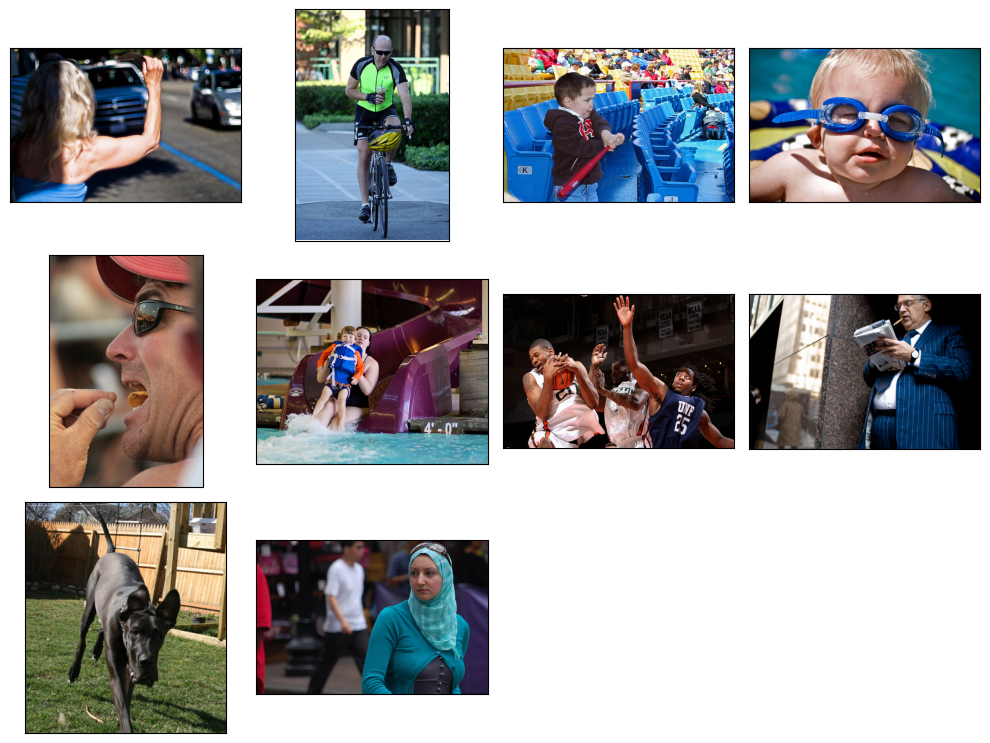

In [15]:
train_folder_name = 'train_images/'
fig = plt.figure(figsize=(10,10))
for i in range(10):
    subplot = fig.add_subplot(4, 4, i+1)
   
    image_path = train_folder_name + train_df['image'][i]
    this_image = cv2.imread(image_path)
    this_image = cv2.cvtColor(this_image, cv2.COLOR_BGR2RGB)

    plt.imshow(this_image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
    #title = f"Image {i+1}\n {train_df['query_text'][i]}"
    #subplot.set_title(title, fontsize=10, pad=2) 

#### Crowd Annotations
В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
* Имя файла изображения
* Идентификатор описания
* Доля людей, подтвердивших, что описание соответствует изображению.
* Количество человек, подтвердивших, что описание соответствует изображению
* Количество человек, подтвердивших, что описание не соответствует изображению

Пропуски отсутствуют, типы данных соответствуют содержимому колонок.

Судя по распределению данных в колонке 'yes_share', большая часть картинок совершенно не совпадает с описанием, меньшая часть совпадает частично; картинка полностью совпадает с описанием в 1323 случаях.

In [16]:
crowd_annotations_df = pd.read_csv('CrowdAnnotations.tsv', sep='\t', header=None, names=['image', 'query_id', 'yes_share', 'yes_votes', 'no_votes'])
#crowd_annotations_df.head()

In [17]:
overall_info(crowd_annotations_df)

Shape:
(47830, 5)

Head:


image                     query_id  yes_share  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   yes_votes  no_votes  
0          3         0  
1          0         3  
2          0         3  
3          0         3  
4          0         3


Describe df:


yes_share     yes_votes      no_votes
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   yes_share  47830 non-null  float64
 3   yes_votes  47830 non-null  int64  
 4   no_votes   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None


Nan values:


image        0.0
query_id     0.0
yes_share    0.0
yes_votes    0.0
no_votes     0.0
dtype: float64


Uniq values count:


image        1000
query_id     1000
yes_share      12
yes_votes       6
no_votes        7
dtype: int64


Full duplicates count:


0

In [18]:
crowd_annotations_df['yes_share'].value_counts()

0.000000    41970
0.333333     3000
0.666667     1360
1.000000     1323
0.250000       96
0.500000       27
0.200000       22
0.750000        9
0.600000        8
0.400000        8
0.800000        4
0.166667        3
Name: yes_share, dtype: int64

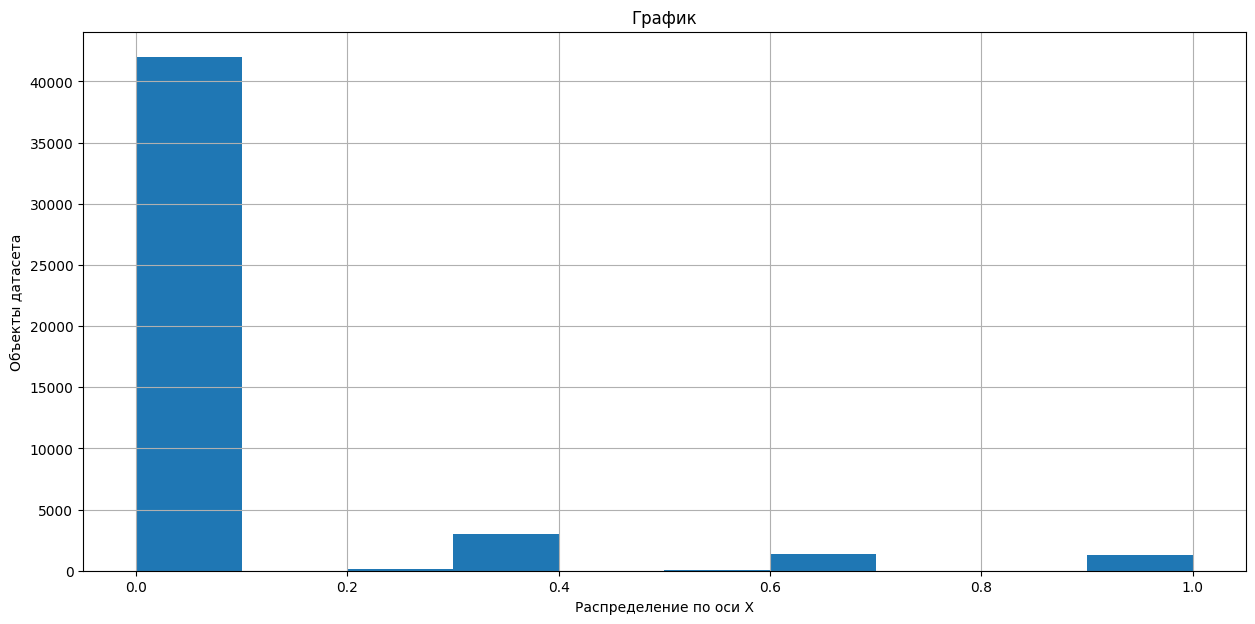

In [19]:
print_hist_for_one_column(df=crowd_annotations_df, xtitle='Распределение по оси Х', 
                              ytitle='Объекты датасета',
                              column_name='yes_share',
                              title='График', 
                              figsize=(15, 7), bins=10)

#### Expert Annotations
В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
* Имя файла изображения.
* Идентификатор описания.
* 3, 4, 5 — оценки трёх экспертов. 

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.     

In [20]:
expert_annotations_df = pd.read_csv('ExpertAnnotations.tsv', sep='\t', header=None, names=['image', 'query_id', 'vote_1', 'vote_2', 'vote_3' ])


In [21]:
overall_info(expert_annotations_df)

Shape:
(5822, 5)

Head:


image                     query_id  vote_1  vote_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2       1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2       1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2       1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2       1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2       1       1   

   vote_3  
0       1  
1       2  
2       2  
3       2  
4       2


Describe df:


vote_1       vote_2       vote_3
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   vote_1    5822 non-null   int64 
 3   vote_2    5822 non-null   int64 
 4   vote_3    5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB
None


Nan values:


image       0.0
query_id    0.0
vote_1      0.0
vote_2      0.0
vote_3      0.0
dtype: float64


Uniq values count:


image       1000
query_id     977
vote_1         4
vote_2         4
vote_3         4
dtype: int64


Full duplicates count:


0

##### Преподготовка данных
Добавим колонку 'expert_vote_final', в которой будет финальная оценка экспертов. 

Для этого сначала преобразуем значения каждого голоса в аналог колонки `yes_share` - значение будет соответствовать тому, насколько описание соответствует картинке, по мнению данного эксперта.

В качестве итоговой оценки экспертов возьмем среднее арифметическое их оценок.

Анализ колонки также показывает, что большая часть описаний не соответствует картинкам.

In [22]:
better_votes = {1: 0.0, 2: 0.25, 3: 0.75, 4: 1}
expert_annotations_df['vote_1'] = expert_annotations_df['vote_1'].map(better_votes)
expert_annotations_df['vote_2'] = expert_annotations_df['vote_2'].map(better_votes)
expert_annotations_df['vote_3'] = expert_annotations_df['vote_3'].map(better_votes)
expert_annotations_df.head()

image                     query_id  vote_1  vote_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     0.0    0.00   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     0.0    0.00   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     0.0    0.00   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     0.0    0.25   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     0.0    0.00   

   vote_3  
0    0.00  
1    0.25  
2    0.25  
3    0.25  
4    0.25

In [23]:
expert_annotations_df['expert_vote_final'] = (expert_annotations_df['vote_1'] + expert_annotations_df['vote_2'] + expert_annotations_df['vote_3']) / 3

In [24]:
expert_annotations_df.head()

image                     query_id  vote_1  vote_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     0.0    0.00   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     0.0    0.00   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     0.0    0.00   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     0.0    0.25   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     0.0    0.00   

   vote_3  expert_vote_final  
0    0.00           0.000000  
1    0.25           0.083333  
2    0.25           0.083333  
3    0.25           0.166667  
4    0.25           0.083333

In [25]:
expert_annotations_df['expert_vote_final'].value_counts()

0.000000    2350
0.083333     965
0.166667     677
0.250000     592
0.416667     309
1.000000     247
0.750000     217
0.583333     191
0.333333      98
0.833333      72
0.916667      60
0.666667      27
0.500000      17
Name: expert_vote_final, dtype: int64

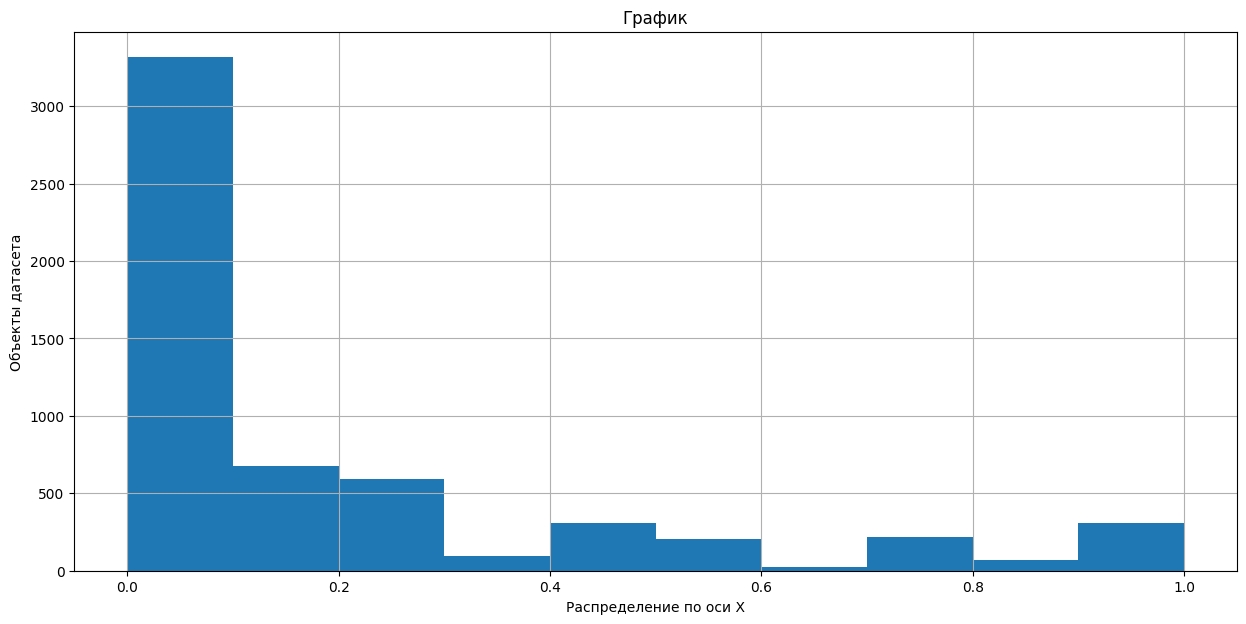

In [26]:
print_hist_for_one_column(df=expert_annotations_df, xtitle='Распределение по оси Х', 
                              ytitle='Объекты датасета',
                              column_name='expert_vote_final',
                              title='График', 
                              figsize=(15, 7), bins=10)

#### Test data
В файле test_queries.csv находится информация, необходимая для тестирования: 
* идентификатор запроса, 
* текст запроса 
* релевантное изображение. 

Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке test_images содержатся изображения для тестирования модели.

Тестовые запросы:

In [27]:
test_queries_df = pd.read_csv('test_queries.csv', sep='|')
overall_info(test_queries_df)

Shape:
(500, 4)

Head:


Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg


Describe df:


Unnamed: 0
count  500.000000
mean   249.500000
std    144.481833
min      0.000000
25%    124.750000
50%    249.500000
75%    374.250000
max    499.000000



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB
None


Nan values:


Unnamed: 0    0.0
query_id      0.0
query_text    0.0
image         0.0
dtype: float64


Uniq values count:


Unnamed: 0    500
query_id      500
query_text    500
image         100
dtype: int64


Full duplicates count:


0

Видим, что в датасете на каждое изображение приходится несколько описаний, которые в целом соответствуют картинке, то есть являются описаниями одной и той же картинки.

In [28]:
test_queries_df.head(20)

Unnamed: 0                     query_id  \
0            0  1177994172_10d143cb8d.jpg#0   
1            1  1177994172_10d143cb8d.jpg#1   
2            2  1177994172_10d143cb8d.jpg#2   
3            3  1177994172_10d143cb8d.jpg#3   
4            4  1177994172_10d143cb8d.jpg#4   
5            5  1232148178_4f45cc3284.jpg#0   
6            6  1232148178_4f45cc3284.jpg#1   
7            7  1232148178_4f45cc3284.jpg#2   
8            8  1232148178_4f45cc3284.jpg#3   
9            9  1232148178_4f45cc3284.jpg#4   
10          10   123997871_6a9ca987b1.jpg#0   
11          11   123997871_6a9ca987b1.jpg#1   
12          12   123997871_6a9ca987b1.jpg#2   
13          13   123997871_6a9ca987b1.jpg#3   
14          14   123997871_6a9ca987b1.jpg#4   
15          15  1319634306_816f21677f.jpg#0   
16          16  1319634306_816f21677f.jpg#1   
17          17  1319634306_816f21677f.jpg#2   
18          18  1319634306_816f21677f.jpg#3   
19          19  1319634306_816f21677f.jpg#4   

                                           query_text  \
0   Two blonde boys , one in a camouflage shirt an...   
1   Two boys are squirting water guns at each other .   
2             Two boys spraying each other with water   
3   Two children wearing jeans squirt water at eac...   
4   Two young boys are squirting water at each oth...   
5                     A baby girl playing at a park .   
6   A closeup of a child on a playground with adul...   
7   A young boy poses for a picture in front of a ...   
8   A young girl is smiling in front of the camera...   
9   There is a little blond hair girl with a green...   
10  Girls wearing sports uniforms and eye protecti...   
11  Several female lacrosse players are going afte...   
12  These girls are in uniforms and are playing fi...   
13  The woman lacrosse player in blue is about to ...   
14                              Women play lacrosse .   
15        A brown dog is sitting in some long grass .   
16             A brown dog sits still on a hillside .   
17            A large tan dog sits on a grassy hill .   
18          A large yellow dog is sitting on a hill .   
19       The dog is sitting on the side of the hill .   

                        image  
0   1177994172_10d143cb8d.jpg  
1   1177994172_10d143cb8d.jpg  
2   1177994172_10d143cb8d.jpg  
3   1177994172_10d143cb8d.jpg  
4   1177994172_10d143cb8d.jpg  
5   1232148178_4f45cc3284.jpg  
6   1232148178_4f45cc3284.jpg  
7   1232148178_4f45cc3284.jpg  
8   1232148178_4f45cc3284.jpg  
9   1232148178_4f45cc3284.jpg  
10   123997871_6a9ca987b1.jpg  
11   123997871_6a9ca987b1.jpg  
12   123997871_6a9ca987b1.jpg  
13   123997871_6a9ca987b1.jpg  
14   123997871_6a9ca987b1.jpg  
15  1319634306_816f21677f.jpg  
16  1319634306_816f21677f.jpg  
17  1319634306_816f21677f.jpg  
18  1319634306_816f21677f.jpg  
19  1319634306_816f21677f.jpg

In [29]:
def show_image(image_name, folder_name):
  image_path = folder_name + image_name
  this_image = cv2.imread(image_path)
  this_image = cv2.cvtColor(this_image, cv2.COLOR_BGR2RGB)
  
  plt.imshow(this_image)
  plt.xticks([])
  plt.yticks([])
  plt.show()

Подходящие к запросам изображения:

In [30]:
test_images_df = pd.read_csv('test_images.csv')
overall_info(test_images_df)

Shape:
(100, 1)

Head:


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg


Describe df:


image
count                         100
unique                        100
top     3356748019_2251399314.jpg
freq                            1



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes
None


Nan values:


image    0.0
dtype: float64


Uniq values count:


image    100
dtype: int64


Full duplicates count:


0

##### Преподготовка данных
Преобразуем колонку 'query_text' в test_queries_df в lower_case.

In [31]:
test_queries_df['query_text'] = test_queries_df['query_text'].apply(lambda x: x.lower())

## Подготовка датасета для обучения модели
### Объединение датафреймов
Датасет `train_df` содержит полезную информацию только о тексте запроса (`query_text`) и id запроса (`query_id`), сочетания с картинкой не информативны. Информативные сочетания запроса и картинки находятся в датафреймах `crowd_annotations_df` и `expert_annotations_df`. 

Поэтому создадим на основе датафрейма `train_df` новый датафрейм `queries_df`. 

In [32]:
queries_df = train_df.drop('image', axis=1)
queries_df.duplicated().sum()

4845

In [33]:
queries_df.drop_duplicates(inplace=True)
queries_df.duplicated().sum()

0

In [34]:
queries_df.nunique()

query_id      977
query_text    977
dtype: int64

Заджойним датафреймы. Наибольшее количество уникальных сочетаний картинки и описания в датафрейме `crowd_annotations_df`, поэтому во избежание потерь информации будем джойнить к нему `expert_annotations_df` и `queries` через `left_join`. 

`crowd_annotations_df` и `expert_annotations_df` джойним по двум полям - `query_id` и `image`, так как они дают уникальную пару.

`queries_df` джойним к получившейся таблице по `query_id`.

In [35]:
# убедились, что записи в датафреймах уникальны по сочетанию query_id и image
print(crowd_annotations_df.duplicated(subset=['query_id', 'image']).sum())
print(expert_annotations_df.duplicated(subset=['query_id', 'image']).sum())

0
0


In [36]:
# проверили количество строк в датафреймах
print(len(crowd_annotations_df))
print(len(expert_annotations_df))
print(len(queries_df))

47830
5822
977


In [37]:
print(crowd_annotations_df.duplicated().sum())
print(expert_annotations_df.duplicated().sum())

0
0


In [38]:
len(expert_annotations_df['expert_vote_final'])

5822

In [39]:
# джойним с expert_annotations_df
merged_train_df = pd.merge(crowd_annotations_df, expert_annotations_df, on=['query_id', 'image'], how='outer')
print(len(merged_train_df))

51323


In [40]:
merged_train_df = pd.merge(merged_train_df, queries_df, on='query_id', how='left')
print(len(merged_train_df))

51323


In [41]:
merged_train_df.head()

image                     query_id  yes_share  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   yes_votes  no_votes  vote_1  vote_2  vote_3  expert_vote_final  \
0        3.0       0.0     NaN     NaN     NaN                NaN   
1        0.0       3.0     NaN     NaN     NaN                NaN   
2        0.0       3.0     NaN     NaN     NaN                NaN   
3        0.0       3.0     NaN     NaN     NaN                NaN   
4        0.0       3.0     NaN     NaN     NaN                NaN   

                                          query_text  
0  a woman is signaling is to traffic , as seen f...  
1          a boy in glasses is wearing a red shirt .  
2   a young boy holds onto a blue handle on a pier .  
3  a woman wearing black clothes , a purple scarf...  
4  an older woman with blond hair rides a bicycle...

In [42]:
merged_train_df.duplicated().sum()

0

Удалим лишние колонки из получившегося датафрейма. Будем считать, что оценка пользователей (из `crowd_annotations_df`) и экспертная оценка (`expert_annotations_df`) имеют одинаковое значение. Пользовательская оценка сохранена в колонке `yes_share`, экспертная - в колонке `expert_vote_final`. 

Колонки `yes_votes`, `no_votes`, `vote_1`, `vote_2`, `vote_3` можно удалить. Колонку `query_id` тоже удалим.

In [43]:
merged_train_df = merged_train_df.drop(['yes_votes', 'no_votes', 'vote_1', 'vote_2', 'vote_3', 'query_id'], axis=1)

In [44]:
overall_info(merged_train_df)

Shape:
(51323, 4)

Head:


image  yes_share  expert_vote_final  \
0  1056338697_4f7d7ce270.jpg        1.0                NaN   
1  1056338697_4f7d7ce270.jpg        0.0                NaN   
2  1056338697_4f7d7ce270.jpg        0.0                NaN   
3  1056338697_4f7d7ce270.jpg        0.0                NaN   
4  1056338697_4f7d7ce270.jpg        0.0                NaN   

                                          query_text  
0  a woman is signaling is to traffic , as seen f...  
1          a boy in glasses is wearing a red shirt .  
2   a young boy holds onto a blue handle on a pier .  
3  a woman wearing black clothes , a purple scarf...  
4  an older woman with blond hair rides a bicycle...


Describe df:


yes_share  expert_vote_final
count  47830.000000        5822.000000
mean       0.068786           0.200160
std        0.207532           0.276339
min        0.000000           0.000000
25%        0.000000           0.000000
50%        0.000000           0.083333
75%        0.000000           0.250000
max        1.000000           1.000000



<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   image              51323 non-null  object 
 1   yes_share          47830 non-null  float64
 2   expert_vote_final  5822 non-null   float64
 3   query_text         50214 non-null  object 
dtypes: float64(2), object(2)
memory usage: 2.0+ MB
None


Nan values:


image                0.000000
yes_share            0.068059
expert_vote_final    0.886562
query_text           0.021608
dtype: float64


Uniq values count:


image                1000
yes_share              12
expert_vote_final      13
query_text            977
dtype: int64


Full duplicates count:


409

#### Удаление дубликатов
В получившемся датасете есть дубликаты. Удалим их. 


In [45]:
merged_train_df.drop_duplicates(inplace=True)

In [46]:
merged_train_df.duplicated().sum()

0

In [47]:
len(merged_train_df)

50914

#### Обработка пропусков
В получившемся датасете есть пустые значения в колонках `expert_final_vote` и `query_text`. Удалим строки с пустым текстом запроса. Как видим, это те же строки, где нет значения image и query_id.

In [48]:
merged_train_df.columns

Index(['image', 'yes_share', 'expert_vote_final', 'query_text'], dtype='object')

In [49]:
merged_train_df[merged_train_df['query_text'].isnull()].count()

image                700
yes_share            700
expert_vote_final      0
query_text             0
dtype: int64

In [50]:
merged_train_df.dropna(subset=['query_text'], inplace=True)
merged_train_df[merged_train_df['query_text'].isnull()].count()

image                0
yes_share            0
expert_vote_final    0
query_text           0
dtype: int64

In [51]:
print(len(merged_train_df))

50214


В колонке `expert_vote_final` 89% пропусков. Заполнять их не будем, зато создадим колонку `final_yes_share`, в которой учтем оценку пользователей и экспертную оценку если она присутствует. Если присутствуют обе оценки, учтем их на равных. Если только одна, то оставим ее как финальную.

In [52]:
def final_yes_share(row):
    if (np.isnan(row['yes_share']) and np.isnan(row['expert_vote_final'])):
        return NaN
    elif np.isnan(row['yes_share']):
        return row['expert_vote_final']
    elif np.isnan(row['expert_vote_final']):
        return row['yes_share']
    else:
        return (row['yes_share'] + row['expert_vote_final']) / 2

In [53]:
merged_train_df['final_yes_share'] = merged_train_df.apply(final_yes_share, axis=1)

In [54]:
merged_train_df.head(10)

image  yes_share  expert_vote_final  \
0  1056338697_4f7d7ce270.jpg   1.000000                NaN   
1  1056338697_4f7d7ce270.jpg   0.000000                NaN   
2  1056338697_4f7d7ce270.jpg   0.000000                NaN   
3  1056338697_4f7d7ce270.jpg   0.000000                NaN   
4  1056338697_4f7d7ce270.jpg   0.000000                NaN   
5  1056338697_4f7d7ce270.jpg   0.000000                NaN   
6  1056338697_4f7d7ce270.jpg   0.000000                NaN   
7  1056338697_4f7d7ce270.jpg   0.333333                NaN   
8  1056338697_4f7d7ce270.jpg   0.000000                NaN   
9  1056338697_4f7d7ce270.jpg   0.000000                NaN   

                                          query_text  final_yes_share  
0  a woman is signaling is to traffic , as seen f...         1.000000  
1          a boy in glasses is wearing a red shirt .         0.000000  
2   a young boy holds onto a blue handle on a pier .         0.000000  
3  a woman wearing black clothes , a purple scarf...         0.000000  
4  an older woman with blond hair rides a bicycle...         0.000000  
5  a woman wearing a white glove peers over the c...         0.000000  
6      a man taking a picture with a silver camera .         0.000000  
7  a woman crosses the street near a man , who is...         0.333333  
8  a man wearing a black shirt and baseball cap s...         0.000000  
9  a woman wears sunglasses and a black coat as s...         0.000000

Теперь можем удалить колонки `yes_share` и `expert_vote_final`.

In [55]:
merged_train_df = merged_train_df.drop(['yes_share', 'expert_vote_final'], axis=1)

In [56]:
overall_info(merged_train_df)

Shape:
(50214, 3)

Head:


image  \
0  1056338697_4f7d7ce270.jpg   
1  1056338697_4f7d7ce270.jpg   
2  1056338697_4f7d7ce270.jpg   
3  1056338697_4f7d7ce270.jpg   
4  1056338697_4f7d7ce270.jpg   

                                          query_text  final_yes_share  
0  a woman is signaling is to traffic , as seen f...              1.0  
1          a boy in glasses is wearing a red shirt .              0.0  
2   a young boy holds onto a blue handle on a pier .              0.0  
3  a woman wearing black clothes , a purple scarf...              0.0  
4  an older woman with blond hair rides a bicycle...              0.0


Describe df:


final_yes_share
count     50214.000000
mean          0.074345
std           0.205763
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000



<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 51322
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            50214 non-null  object 
 1   query_text       50214 non-null  object 
 2   final_yes_share  50214 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.5+ MB
None


Nan values:


image              0.0
query_text         0.0
final_yes_share    0.0
dtype: float64


Uniq values count:


image              1000
query_text          977
final_yes_share      63
dtype: int64


Full duplicates count:


0

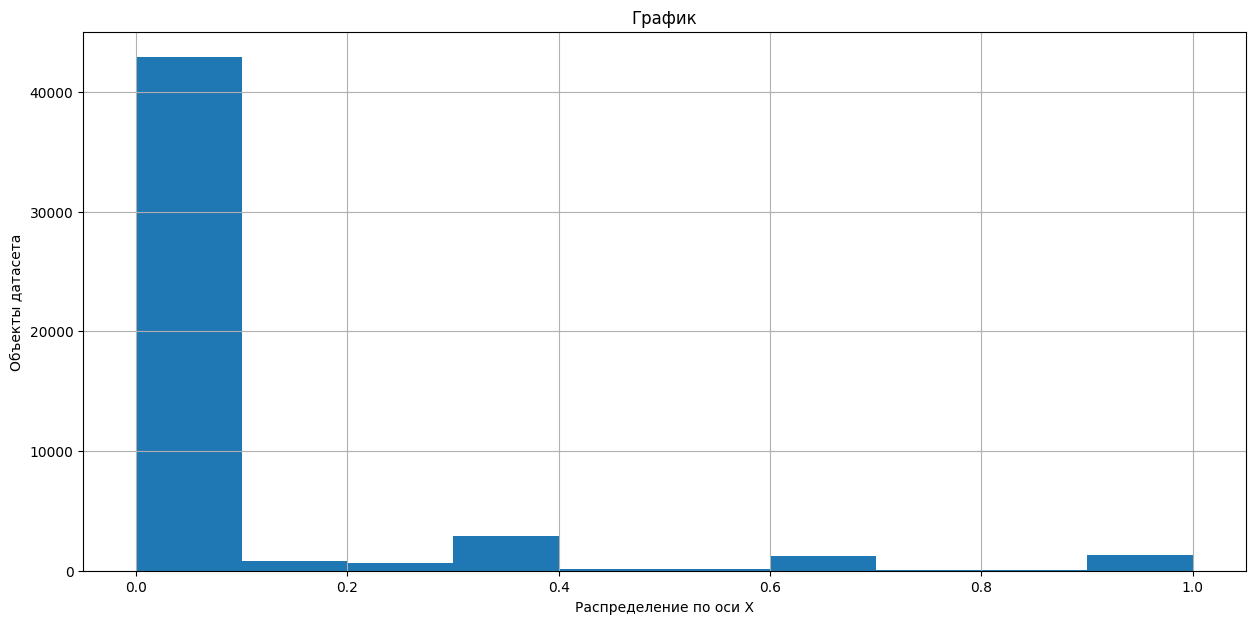

In [57]:
print_hist_for_one_column(df=merged_train_df, xtitle='Распределение по оси Х', 
                              ytitle='Объекты датасета',
                              column_name='final_yes_share',
                              title='График', 
                              figsize=(15, 7), bins=10)

Датасет очищен от пустых значений. Осталось 50214 строк.

### Удаление из датасета запрещенных запросов
Приведем датасет в соответствие с законодательством. Удалим из него все изображения, связанные с детьми, и соответствующие описания.


#### Стоп лист
Создадим стоп лист, чтоб исключить из поиска слова, которые относятся к детям.

In [58]:
stop_list = ['kid', 'kids', 'toddler', 'toddlers', 'infant', 'infants', 
             'baby', 'babies', 'newborn', 'newborns', 'child', 'children', 
             'teen', 'teens', 'adolescent', 'adolescents', 'youth', 'youths', 
             'minor', 'minors', 'girl', 'girls', 'boy', 'boys', 'student', 'students', 
             'pupil', 'pupils', 'junior', 'juniors', 'kindergarten', 'kindergarteners', 
             'elementary', 'elementary students', 'middle school', 'middle schoolers', 
             'high school', 'high schoolers', 'college', 'college students', 
             'university', 'graduation', 'graduations', 'schoolgirl', 'schoolgirls', 
             'schoolboy', 'schoolboys', 'school', 'schools', 
             'classroom', 'classrooms', 'playground', 'playgrounds']

#stop_list = [ word.lower() for word in stop_list]
stop_list = set(stop_list)

#### Создание датасета с истинными совпадениями картинки и описания



Сформируем датасет который будет сочетать query_text и image, которые точно соответствуют друг другу. Датасет составим на основе train_df, распарсив поле query_id.

In [59]:
train_df.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  a young child is wearing blue goggles and sitt...  
1  a young child is wearing blue goggles and sitt...  
2  a young child is wearing blue goggles and sitt...  
3  a young child is wearing blue goggles and sitt...  
4  a young child is wearing blue goggles and sitt...

In [60]:
real_matches_df = train_df.copy().drop('image', axis=1)
real_matches_df['real_image'] = real_matches_df['query_id'].apply(lambda x: x.split('#')[0])
print(len(real_matches_df))
print(len(real_matches_df.drop_duplicates()))
real_matches_df = real_matches_df.drop_duplicates().drop('query_id', axis=1)
real_matches_df.head()

5822
977


query_text  \
0   a young child is wearing blue goggles and sitt...   
12  a girl wearing a yellow shirt and sunglasses s...   
22    a man sleeps under a blanket on a city street .   
27  a woman plays with long red ribbons in an empt...   
31         chinese market street in the winter time .   

                   real_image  
0   2549968784_39bfbe44f9.jpg  
12  2718495608_d8533e3ac5.jpg  
22  3181701312_70a379ab6e.jpg  
27  3207358897_bfa61fa3c6.jpg  
31  3286822339_5535af6b93.jpg

In [61]:
print(len(real_matches_df['query_text']))
print(len(real_matches_df['query_text'].unique()))
print(len(real_matches_df['real_image']))
print(len(real_matches_df['real_image'].unique()))


977
977
977
977


In [62]:
real_matches_dict = dict(real_matches_df[['real_image', 'query_text']].values)


Добавим в merged_train_df колонку real_description, в которой будет описание, которое точно соответствует изображению.

In [63]:
merged_train_df['real_query_text'] = merged_train_df['image'].map(real_matches_dict)
merged_train_df.head()

image  \
0  1056338697_4f7d7ce270.jpg   
1  1056338697_4f7d7ce270.jpg   
2  1056338697_4f7d7ce270.jpg   
3  1056338697_4f7d7ce270.jpg   
4  1056338697_4f7d7ce270.jpg   

                                          query_text  final_yes_share  \
0  a woman is signaling is to traffic , as seen f...              1.0   
1          a boy in glasses is wearing a red shirt .              0.0   
2   a young boy holds onto a blue handle on a pier .              0.0   
3  a woman wearing black clothes , a purple scarf...              0.0   
4  an older woman with blond hair rides a bicycle...              0.0   

                                     real_query_text  
0  a woman is signaling is to traffic , as seen f...  
1  a woman is signaling is to traffic , as seen f...  
2  a woman is signaling is to traffic , as seen f...  
3  a woman is signaling is to traffic , as seen f...  
4  a woman is signaling is to traffic , as seen f...

In [64]:
merged_train_df['real_query_text'].isna().mean()

0.022085474170550047

In [65]:
merged_train_df.isna().mean()

image              0.000000
query_text         0.000000
final_yes_share    0.000000
real_query_text    0.022085
dtype: float64

На этом же этапе добавим в датасет дополнительную информацию: 
real_matches_df приведем к виду merged_train_df, учтем таргет равным единице и объединим датасеты. Информации для обучения будет больше, кроме того, будет несколько сглажен дисбаланс классов.

In [66]:
real_matches_df['final_yes_share'] = 1.0
real_matches_df['real_query_text'] = real_matches_df['query_text']
real_matches_df.rename(columns={'real_image': 'image'}, inplace=True)

real_matches_df.head()

query_text  \
0   a young child is wearing blue goggles and sitt...   
12  a girl wearing a yellow shirt and sunglasses s...   
22    a man sleeps under a blanket on a city street .   
27  a woman plays with long red ribbons in an empt...   
31         chinese market street in the winter time .   

                        image  final_yes_share  \
0   2549968784_39bfbe44f9.jpg              1.0   
12  2718495608_d8533e3ac5.jpg              1.0   
22  3181701312_70a379ab6e.jpg              1.0   
27  3207358897_bfa61fa3c6.jpg              1.0   
31  3286822339_5535af6b93.jpg              1.0   

                                      real_query_text  
0   a young child is wearing blue goggles and sitt...  
12  a girl wearing a yellow shirt and sunglasses s...  
22    a man sleeps under a blanket on a city street .  
27  a woman plays with long red ribbons in an empt...  
31         chinese market street in the winter time .

In [67]:
print(merged_train_df.shape)
print(real_matches_df.shape)

extended_train_df = pd.concat([merged_train_df, real_matches_df])
extended_train_df.shape

(50214, 4)
(977, 4)


(51191, 4)

In [68]:
# на всякий случай перемешаем строки и сбросим индексы
extended_train_df = extended_train_df.sample(frac=1).reset_index(drop=True)
extended_train_df.index

RangeIndex(start=0, stop=51191, step=1)

In [69]:
extended_train_df.isna().mean()

image              0.000000
query_text         0.000000
final_yes_share    0.000000
real_query_text    0.021664
dtype: float64

#### Удаление нежелательного контента из объединенного датасета

In [70]:
def unwanted_query(text):
  text_splitted = set(text.split())
  intersection = text_splitted & stop_list

  if intersection:
        return None
  else:
      return text

In [71]:
cleared_train_df = extended_train_df.copy()
print(cleared_train_df['real_query_text'].isna().mean())
cleared_train_df['real_query_text'].fillna('No real description', inplace=True)
print(cleared_train_df['real_query_text'].isna().mean())

0.02166396436873669
0.0


In [72]:
cleared_train_df['query_text_checked'] = cleared_train_df['real_query_text'].apply(unwanted_query)

In [73]:
cleared_train_df.head()

image  \
0  2473689180_e9d8fd656a.jpg   
1  2393264648_a280744f97.jpg   
2  2120411340_104eb610b1.jpg   
3  3320032226_63390d74a6.jpg   
4  3538213870_9856a76b2a.jpg   

                                          query_text  final_yes_share  \
0  a person hanging from a parachute makes a spla...         0.333333   
1  a man dressed in winter clothes is on the beac...         0.000000   
2       a dog stands on the side of a grassy cliff .         0.000000   
3  an in-line skater is attempting a trick in a l...         0.000000   
4  two girls pass two boys by a tree in a neon li...         0.000000   

                                     real_query_text  \
0  a wakeboarder is attempting a trick while hold...   
1  a man and a girl are at the shoreline while th...   
2  a white dog looks at a nervous cow in a mounta...   
3  a little girl in a red snowsuit sits on a snow...   
4   a little girl twirls around in a flowery dress .   

                                  query_text_checked  
0  a wakeboarder is attempting a trick while hold...  
1                                               None  
2  a white dog looks at a nervous cow in a mounta...  
3                                               None  
4                                               None

Теперь можно удалить строки с нежелательным контентом, а затем удалить колонки `query_text_checked` как дублирующую, а колонку `real_query_text` как не соответствующую таргету (ему соответствует текст в колонке `query_text`).

In [74]:
cleared_train_df.dropna(subset=['query_text_checked'], inplace=True)
cleared_train_df.isna().mean()

image                 0.0
query_text            0.0
final_yes_share       0.0
real_query_text       0.0
query_text_checked    0.0
dtype: float64

In [75]:
cleared_train_df.head()

image  \
0  2473689180_e9d8fd656a.jpg   
2  2120411340_104eb610b1.jpg   
6  2083434441_a93bc6306b.jpg   
7   537559285_29be110134.jpg   
8  3123463486_f5b36a3624.jpg   

                                          query_text  final_yes_share  \
0  a person hanging from a parachute makes a spla...         0.333333   
2       a dog stands on the side of a grassy cliff .         0.000000   
6  an older woman with blond hair rides a bicycle...         1.000000   
7          the dog is jumping up beside a red wall .         0.000000   
8  a woman in a black cap and outfit sits in the ...         0.000000   

                                     real_query_text  \
0  a wakeboarder is attempting a trick while hold...   
2  a white dog looks at a nervous cow in a mounta...   
6  an older woman with blond hair rides a bicycle...   
7  collie jumping over a training hurdle that is ...   
8                     a little dog running on sand .   

                                  query_text_checked  
0  a wakeboarder is attempting a trick while hold...  
2  a white dog looks at a nervous cow in a mounta...  
6  an older woman with blond hair rides a bicycle...  
7  collie jumping over a training hurdle that is ...  
8                     a little dog running on sand .

In [76]:
cleared_train_df.drop(columns=['query_text_checked', 'real_query_text'], inplace=True)

В получившемся датасете 371 дубликат, уберем их.


In [77]:
print(cleared_train_df.duplicated().sum())
cleared_train_df.drop_duplicates(inplace=True)
cleared_train_df.duplicated().sum()

371


0

In [78]:
cleared_train_df.head()

image  \
0  2473689180_e9d8fd656a.jpg   
2  2120411340_104eb610b1.jpg   
6  2083434441_a93bc6306b.jpg   
7   537559285_29be110134.jpg   
8  3123463486_f5b36a3624.jpg   

                                          query_text  final_yes_share  
0  a person hanging from a parachute makes a spla...         0.333333  
2       a dog stands on the side of a grassy cliff .         0.000000  
6  an older woman with blond hair rides a bicycle...         1.000000  
7          the dog is jumping up beside a red wall .         0.000000  
8  a woman in a black cap and outfit sits in the ...         0.000000

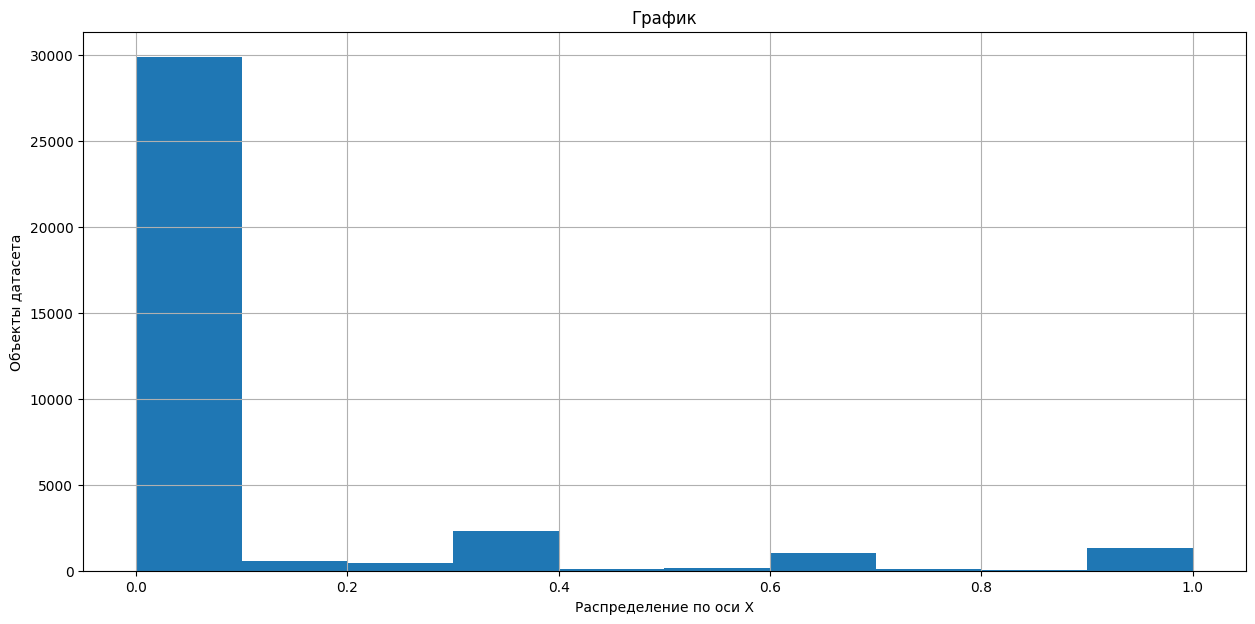

In [79]:
print_hist_for_one_column(df=cleared_train_df, xtitle='Распределение по оси Х', 
                              ytitle='Объекты датасета',
                              column_name='final_yes_share',
                              title='График', 
                              figsize=(15, 7), bins=10)

### Вывод по подготовленному датасету
В подготовленном датасете осталась 35_949 строк. Полных дубликатов нет, пропусков нет, типы данных соответствуют содержимому колонок.

Целевой признак содержится в колонке `final_yes_share`. Обучающие признаки в колонках `image`, `query_text`.

Большая часть картинок по-прежнему не соответствует описаниям.

Можно приступать к преобразованию обучающих признаков в вектора.

In [80]:
overall_info(cleared_train_df)

Shape:
(35949, 3)

Head:


image  \
0  2473689180_e9d8fd656a.jpg   
2  2120411340_104eb610b1.jpg   
6  2083434441_a93bc6306b.jpg   
7   537559285_29be110134.jpg   
8  3123463486_f5b36a3624.jpg   

                                          query_text  final_yes_share  
0  a person hanging from a parachute makes a spla...         0.333333  
2       a dog stands on the side of a grassy cliff .         0.000000  
6  an older woman with blond hair rides a bicycle...         1.000000  
7          the dog is jumping up beside a red wall .         0.000000  
8  a woman in a black cap and outfit sits in the ...         0.000000


Describe df:


final_yes_share
count     35949.000000
mean          0.091232
std           0.232159
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000



<class 'pandas.core.frame.DataFrame'>
Int64Index: 35949 entries, 0 to 51189
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            35949 non-null  object 
 1   query_text       35949 non-null  object 
 2   final_yes_share  35949 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB
None


Nan values:


image              0.0
query_text         0.0
final_yes_share    0.0
dtype: float64


Uniq values count:


image              707
query_text         977
final_yes_share     59
dtype: int64


Full duplicates count:


0

In [81]:
# сохраним копию датасета
safe_df = cleared_train_df.copy()

### Векторизация изображений
Векторизируем изображения.

In [82]:
images = cleared_train_df.drop_duplicates(subset=['image'])['image']

In [83]:
images.head()

0    2473689180_e9d8fd656a.jpg
2    2120411340_104eb610b1.jpg
6    2083434441_a93bc6306b.jpg
7     537559285_29be110134.jpg
8    3123463486_f5b36a3624.jpg
Name: image, dtype: object

In [84]:
type(images)

pandas.core.series.Series

In [85]:
# импорт здесь, т.к. где-то в тексте я случайно переопределяю image
# from tensorflow.keras.preprocessing import image
def vectorize_image(img_path, model): 
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features



In [86]:
def create_vectorized_images(images, folder_name):
  model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3),
                  pooling='max')
  
  vectorized_images = []

  for path in images:
      full_path = folder_name + path
      vectorized = vectorize_image(full_path, model)
      vectorized_images.append(vectorized)

  return vectorized_images

In [87]:
vectorized_images = create_vectorized_images(images, train_folder_name)
len(vectorized_images)

1/1 [==============================] - 0s 44ms/step


707

In [88]:
images_df = pd.DataFrame({'image': images, 'vectorized_image': vectorized_images})
images_df.head()

image  \
0  2473689180_e9d8fd656a.jpg   
2  2120411340_104eb610b1.jpg   
6  2083434441_a93bc6306b.jpg   
7   537559285_29be110134.jpg   
8  3123463486_f5b36a3624.jpg   

                                    vectorized_image  
0  (tf.Tensor(0.011928897, shape=(), dtype=float3...  
2  (tf.Tensor(0.019007677, shape=(), dtype=float3...  
6  (tf.Tensor(0.0026930592, shape=(), dtype=float...  
7  (tf.Tensor(0.0020546808, shape=(), dtype=float...  
8  (tf.Tensor(0.016297033, shape=(), dtype=float3...

In [89]:
images_dict = dict(images_df.values)

In [90]:
# Проверили, что все длины токенов одинаковые
lengths = images_df['vectorized_image'].map(lambda x: len(x))
Counter(lengths)

Counter({2048: 707})

In [91]:
# Или проверили так:
print(len(images_df['vectorized_image']))
print(len(images_df['vectorized_image'][0]))

707
2048


### Векторизация текстов
Создадим эмбеддинги на основе текстов.



In [92]:
texts = cleared_train_df.drop_duplicates(subset=['query_text'])['query_text']

In [93]:
print(texts.shape)
texts.head()

(977,)


0    a person hanging from a parachute makes a spla...
2         a dog stands on the side of a grassy cliff .
6    an older woman with blond hair rides a bicycle...
7            the dog is jumping up beside a red wall .
8    a woman in a black cap and outfit sits in the ...
Name: query_text, dtype: object

#### Embeddings
Превратим тексты в эмбеддинги.

In [94]:
#from transformers import TFBertModel, DistilBertModel, BertTokenizer
def create_embeddings(texts):
  bert_model = TFBertModel.from_pretrained('bert-base-cased')
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

  encoded_inputs = tokenizer.batch_encode_plus(texts, padding='max_length', max_length=max_length, truncation=True, return_tensors='tf')

  outputs = bert_model(encoded_inputs)

  embeddings = outputs[0][:, 0, :]  # take CLS token's embedding

  return embeddings

In [95]:
def create_single_embedded_texts(embeddings):
  single_embedded_texts = []

  for i in range(len(embeddings)):
    reshaped = tf.reshape(embeddings[i], [-1])
    floated = tf.cast(reshaped, dtype=tf.float32)
    single_embedded_texts.append(floated)

  return single_embedded_texts

In [96]:
lengths = [len(text) for text in texts]
mean_length = np.mean(lengths)
std_length = np.std(lengths)
max_length = int(np.ceil(mean_length + 2*std_length))

In [97]:
embeddings = create_embeddings(texts)
single_embedded_texts = create_single_embedded_texts(embeddings)
embedded_texts_df = pd.DataFrame({'query_text': texts, 'embedded_text': single_embedded_texts})
embedded_texts_df.head()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


query_text  \
0  a person hanging from a parachute makes a spla...   
2       a dog stands on the side of a grassy cliff .   
6  an older woman with blond hair rides a bicycle...   
7          the dog is jumping up beside a red wall .   
8  a woman in a black cap and outfit sits in the ...   

                                       embedded_text  
0  (tf.Tensor(-0.016880628, shape=(), dtype=float...  
2  (tf.Tensor(0.27202174, shape=(), dtype=float32...  
6  (tf.Tensor(0.047133528, shape=(), dtype=float3...  
7  (tf.Tensor(0.18157163, shape=(), dtype=float32...  
8  (tf.Tensor(0.008526662, shape=(), dtype=float3...

In [98]:
# Проверили, что все длины эмбеддингов одинаковые и правильные
lengths = embedded_texts_df['embedded_text'].map(lambda x: len(x))
Counter(lengths)

Counter({768: 977})

In [99]:
print(len(embedded_texts_df['embedded_text']))
print(len(embedded_texts_df['embedded_text'][0]))

977
768


In [100]:
embedded_texts_dict = dict(embedded_texts_df.values)

### Создание финального датасета для обучения модели
Соберем финальный датасет для обучения модели.

In [101]:
cleared_train_df.head()

image  \
0  2473689180_e9d8fd656a.jpg   
2  2120411340_104eb610b1.jpg   
6  2083434441_a93bc6306b.jpg   
7   537559285_29be110134.jpg   
8  3123463486_f5b36a3624.jpg   

                                          query_text  final_yes_share  
0  a person hanging from a parachute makes a spla...         0.333333  
2       a dog stands on the side of a grassy cliff .         0.000000  
6  an older woman with blond hair rides a bicycle...         1.000000  
7          the dog is jumping up beside a red wall .         0.000000  
8  a woman in a black cap and outfit sits in the ...         0.000000

#### Add images vectorized

In [102]:
final_train_df = cleared_train_df.copy()
final_train_df['image'] = final_train_df['image'].map(images_dict)

In [103]:
cleared_train_df.head()

image  \
0  2473689180_e9d8fd656a.jpg   
2  2120411340_104eb610b1.jpg   
6  2083434441_a93bc6306b.jpg   
7   537559285_29be110134.jpg   
8  3123463486_f5b36a3624.jpg   

                                          query_text  final_yes_share  
0  a person hanging from a parachute makes a spla...         0.333333  
2       a dog stands on the side of a grassy cliff .         0.000000  
6  an older woman with blond hair rides a bicycle...         1.000000  
7          the dog is jumping up beside a red wall .         0.000000  
8  a woman in a black cap and outfit sits in the ...         0.000000

In [104]:
final_train_df.head()

image  \
0  (tf.Tensor(0.011928897, shape=(), dtype=float3...   
2  (tf.Tensor(0.019007677, shape=(), dtype=float3...   
6  (tf.Tensor(0.0026930592, shape=(), dtype=float...   
7  (tf.Tensor(0.0020546808, shape=(), dtype=float...   
8  (tf.Tensor(0.016297033, shape=(), dtype=float3...   

                                          query_text  final_yes_share  
0  a person hanging from a parachute makes a spla...         0.333333  
2       a dog stands on the side of a grassy cliff .         0.000000  
6  an older woman with blond hair rides a bicycle...         1.000000  
7          the dog is jumping up beside a red wall .         0.000000  
8  a woman in a black cap and outfit sits in the ...         0.000000

#### Add text embeddings

In [105]:
final_train_df.head()

image  \
0  (tf.Tensor(0.011928897, shape=(), dtype=float3...   
2  (tf.Tensor(0.019007677, shape=(), dtype=float3...   
6  (tf.Tensor(0.0026930592, shape=(), dtype=float...   
7  (tf.Tensor(0.0020546808, shape=(), dtype=float...   
8  (tf.Tensor(0.016297033, shape=(), dtype=float3...   

                                          query_text  final_yes_share  
0  a person hanging from a parachute makes a spla...         0.333333  
2       a dog stands on the side of a grassy cliff .         0.000000  
6  an older woman with blond hair rides a bicycle...         1.000000  
7          the dog is jumping up beside a red wall .         0.000000  
8  a woman in a black cap and outfit sits in the ...         0.000000

In [106]:
def concatenate_features_np(row):
  concatenated_features = np.concatenate((row['image'], row['query_text']), axis=0)
  return concatenated_features

In [107]:
embeddings_final_train_df = final_train_df.copy()

embeddings_final_train_df['query_text'] = embeddings_final_train_df['query_text'].map(embedded_texts_dict)

In [108]:
embeddings_final_train_df.head()

image  \
0  (tf.Tensor(0.011928897, shape=(), dtype=float3...   
2  (tf.Tensor(0.019007677, shape=(), dtype=float3...   
6  (tf.Tensor(0.0026930592, shape=(), dtype=float...   
7  (tf.Tensor(0.0020546808, shape=(), dtype=float...   
8  (tf.Tensor(0.016297033, shape=(), dtype=float3...   

                                          query_text  final_yes_share  
0  (tf.Tensor(-0.016880628, shape=(), dtype=float...         0.333333  
2  (tf.Tensor(0.27202174, shape=(), dtype=float32...         0.000000  
6  (tf.Tensor(0.047133528, shape=(), dtype=float3...         1.000000  
7  (tf.Tensor(0.18157163, shape=(), dtype=float32...         0.000000  
8  (tf.Tensor(0.008526662, shape=(), dtype=float3...         0.000000

In [109]:
embeddings_final_train_df['features_np'] = embeddings_final_train_df.apply(concatenate_features_np, axis=1)
#embeddings_final_train_df['features_tf'] = embeddings_final_train_df.apply(concatenate_features_tf, axis=1)

In [110]:
embeddings_final_train_df.head()

image  \
0  (tf.Tensor(0.011928897, shape=(), dtype=float3...   
2  (tf.Tensor(0.019007677, shape=(), dtype=float3...   
6  (tf.Tensor(0.0026930592, shape=(), dtype=float...   
7  (tf.Tensor(0.0020546808, shape=(), dtype=float...   
8  (tf.Tensor(0.016297033, shape=(), dtype=float3...   

                                          query_text  final_yes_share  \
0  (tf.Tensor(-0.016880628, shape=(), dtype=float...         0.333333   
2  (tf.Tensor(0.27202174, shape=(), dtype=float32...         0.000000   
6  (tf.Tensor(0.047133528, shape=(), dtype=float3...         1.000000   
7  (tf.Tensor(0.18157163, shape=(), dtype=float32...         0.000000   
8  (tf.Tensor(0.008526662, shape=(), dtype=float3...         0.000000   

                                         features_np  
0  [0.011928897, 0.00833487, 0.0075016525, 0.0123...  
2  [0.019007677, 0.028537314, 0.0, 0.0, 0.0140325...  
6  [0.0026930592, 0.013675627, 0.0021591373, 0.0,...  
7  [0.0020546808, 0.015935058, 0.011835582, 0.028...  
8  [0.016297033, 0.035904996, 0.00074716384, 0.01...

In [111]:
embeddings_final_train_df.dtypes

image               object
query_text          object
final_yes_share    float64
features_np         object
dtype: object

In [112]:
print(len(embeddings_final_train_df['features_np']))
print(len(embeddings_final_train_df['features_np'][0]))

35949
2816


#### Сохранение датасетов на Google Drive и импорт обратно


In [113]:
np.save('embeddings_final_train_df.npy', embeddings_final_train_df.values)

In [114]:
%ls

CrowdAnnotations.tsv           test_images/      train_dataset.csv
embeddings_final_train_df.npy  test_images.csv   train_images/
ExpertAnnotations.tsv          test_queries.csv


Чтоб не пересоздавать каждый раз, сделаем импорт готовых датасетов с Google Drive. Иморт работает корректно, но отключила его, т.к. он не используется.

In [115]:
# imported_numpy_array = np.load('embeddings_final_train_df.npy', allow_pickle=True)
# embeddings_final_train_df_imported = pd.DataFrame(imported_numpy_array, columns=['image', 'query_text', 'final_yes_share', 'features_np'])

In [116]:
# display(embeddings_final_train_df_imported.head())
# embeddings_final_train_df_imported.dtypes

In [117]:
# embeddings_final_train_df_imported['features_np'][0].size

In [118]:
# embeddings_final_train_df_imported['final_yes_share'] = embeddings_final_train_df_imported['final_yes_share'].astype('float')

In [119]:
# embeddings_final_train_df = embeddings_final_train_df_imported

In [120]:
# embeddings_final_train_df.dtypes

### Разделение на трейн и валид по индексам
Сбросим индексы датасетов, чтоб они шли по порядку. 

In [121]:
print(embeddings_final_train_df.index)
embeddings_final_train_df = embeddings_final_train_df.reset_index(drop=True)
embeddings_final_train_df.index

Int64Index([    0,     2,     6,     7,     8,    11,    12,    14,    15,
               16,
            ...
            51177, 51178, 51179, 51180, 51181, 51182, 51186, 51187, 51188,
            51189],
           dtype='int64', length=35949)


RangeIndex(start=0, stop=35949, step=1)

Создадим метод для обучения моделей на кросс-валидации с помощью GroupShuffleSplit.

In [122]:
def train_model_on_cv2(estimator, df, features_column_name, target_column_name='final_yes_share', **args):
  rmse_train_list = []
  rmse_valid_list = []
  gss = GroupShuffleSplit(n_splits=5, train_size=.7, random_state=MY_RANDOM)
  gss_cv_split = gss.split(X=df['query_text'], y=df['final_yes_share'], groups=df['image'].index.values)
  
  features = df[features_column_name].values
  target = df[target_column_name].values

  for cv_train_index, cv_valid_index in gss_cv_split:
    features_train = np.vstack(features[cv_train_index])
    target_train = target[cv_train_index]

    features_valid = np.vstack(features[cv_valid_index])
    target_valid = target[cv_valid_index]

    if isinstance(estimator, tf.keras.Model):
      estimator.fit(features_train, target_train, 
                    validation_data=(features_valid, target_valid), **args)
    else:
      estimator.fit(features_train, target_train, **args)

    predicted_train = estimator.predict(features_train)
    predicted_valid = estimator.predict(features_valid)

    rmse_train = mean_squared_error(target_train, predicted_train, squared=False)
    rmse_valid = mean_squared_error(target_valid, predicted_valid, squared=False)

    rmse_train_list.append(rmse_train)
    rmse_valid_list.append(rmse_valid)


  mean_rmse_train = sum(rmse_train_list) / len(rmse_train_list)
  mean_rmse_valid = sum(rmse_valid_list) / len(rmse_valid_list)
  print('RMSE train:', rmse_train_list)
  print('Mean RMSE train:', mean_rmse_train)
  print('RMSE valid:', rmse_valid_list)
  print('Mean RMSE valid:', mean_rmse_valid)
  return mean_rmse_train, mean_rmse_valid


## Подготовка датасета для тестирования модели
Итоговая модель будет обучаться на эмбеддингах, поэтому превратим тексты в эмбеддинги, а изображения - в вектора.

Дальнейший план использования для предсказаний моделью будет такой:

1) на вход получаем запрос от пользователя - текст;

2) текст проверяется на запрещенные слова, если они есть - выводится предупреждение вместо картинки;

3) если запрещенных слов нет, эмбеддинг текста конкатенируется со всеми векторами изображений - это наш демонстрационный датасет, модель предсказывает степень соответствия картинки тексту;

4) выводится картинка с максимальным соответствием.

Поэтому сейчас векторизируем тексты и картинки, напишем функцию для создания датасета "на лету" под случайный текст запроса.

In [123]:
%ls

CrowdAnnotations.tsv           test_images/      train_dataset.csv
embeddings_final_train_df.npy  test_images.csv   train_images/
ExpertAnnotations.tsv          test_queries.csv


In [124]:
test_queries_df.head(5)

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  two blonde boys , one in a camouflage shirt an...   
1  two boys are squirting water guns at each other .   
2            two boys spraying each other with water   
3  two children wearing jeans squirt water at eac...   
4  two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [125]:
test_images_df.head()

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

#### Векторизация изображений

In [126]:
#from tensorflow.keras.preprocessing import image
# я где-то переопределяю image, импотрирую снова, чтоб код не ломался

test_folder_name = 'test_images/'
test_images = test_images_df['image']
test_vectorized_images = create_vectorized_images(test_images, test_folder_name)
print(len(vectorized_images))
test_images_df = pd.DataFrame({'image': test_images, 'vectorized_image': test_vectorized_images})
test_images_df.head()

1/1 [==============================] - 0s 21ms/step
707


image  \
0  3356748019_2251399314.jpg   
1  2887171449_f54a2b9f39.jpg   
2  3089107423_81a24eaf18.jpg   
3  1429546659_44cb09cbe2.jpg   
4  1177994172_10d143cb8d.jpg   

                                    vectorized_image  
0  (tf.Tensor(0.009105164, shape=(), dtype=float3...  
1  (tf.Tensor(0.014890492, shape=(), dtype=float3...  
2  (tf.Tensor(0.0053209253, shape=(), dtype=float...  
3  (tf.Tensor(0.0037939234, shape=(), dtype=float...  
4  (tf.Tensor(0.009408536, shape=(), dtype=float3...

#### Векторизация текстов
Превратим тексты в эмбеддинги.

In [127]:
texts = test_queries_df['query_text']
# возьмем max_length из тренировочного датасета, чтоб обеспечить совместимость
embeddings = create_embeddings(texts)
single_embedded_texts = create_single_embedded_texts(embeddings)
embedded_texts_df = pd.DataFrame({'query_text': texts, 'embedded_text': single_embedded_texts})
embedded_texts_df.head()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


query_text  \
0  two blonde boys , one in a camouflage shirt an...   
1  two boys are squirting water guns at each other .   
2            two boys spraying each other with water   
3  two children wearing jeans squirt water at eac...   
4  two young boys are squirting water at each oth...   

                                       embedded_text  
0  (tf.Tensor(0.17746708, shape=(), dtype=float32...  
1  (tf.Tensor(0.21590278, shape=(), dtype=float32...  
2  (tf.Tensor(0.120360225, shape=(), dtype=float3...  
3  (tf.Tensor(0.31574324, shape=(), dtype=float32...  
4  (tf.Tensor(0.25664246, shape=(), dtype=float32...

In [128]:
test_texts_df = embedded_texts_df
test_texts_dict = dict(test_texts_df.values)

In [129]:
print(len(test_texts_df['embedded_text']))
print(len(test_texts_df['embedded_text'][0]))

500
768


### Датасет для демонстрации
Предполагается, что для каждой демонстрации будет создаваться отдельный датасет: входной текст в виде вектора будет объединяться со всеми изображениями. Создадим функцию для создания такого датасета.

In [130]:
def concatenate_features_np(row):
  concatenated_features = np.concatenate((row['vectorized_image'], row['embedded_text']), axis=0)
  return concatenated_features

In [131]:
def create_demo_dataset(text):
  text = unwanted_query(text)
  if text is None:
    print('Sorry, this content violates the rules of your country! Try something else, please')
    return
  elif text not in list(test_texts_dict.keys()):
    print('Sorry, this text is not from the test dataset, try something else!')
    return
  else:
    demo_df = test_images_df.copy()
    demo_df['query_text'] = text
    #print(test_texts_dict[text])
    demo_df['embedded_text'] = demo_df['query_text'].map(test_texts_dict)
    demo_df['features'] = demo_df.apply(concatenate_features_np, axis=1)

  return demo_df

In [132]:
my_demo = create_demo_dataset('person jumping into the water .')
my_demo.head()

image  \
0  3356748019_2251399314.jpg   
1  2887171449_f54a2b9f39.jpg   
2  3089107423_81a24eaf18.jpg   
3  1429546659_44cb09cbe2.jpg   
4  1177994172_10d143cb8d.jpg   

                                    vectorized_image  \
0  (tf.Tensor(0.009105164, shape=(), dtype=float3...   
1  (tf.Tensor(0.014890492, shape=(), dtype=float3...   
2  (tf.Tensor(0.0053209253, shape=(), dtype=float...   
3  (tf.Tensor(0.0037939234, shape=(), dtype=float...   
4  (tf.Tensor(0.009408536, shape=(), dtype=float3...   

                        query_text  \
0  person jumping into the water .   
1  person jumping into the water .   
2  person jumping into the water .   
3  person jumping into the water .   
4  person jumping into the water .   

                                       embedded_text  \
0  (tf.Tensor(-0.05796925, shape=(), dtype=float3...   
1  (tf.Tensor(-0.05796925, shape=(), dtype=float3...   
2  (tf.Tensor(-0.05796925, shape=(), dtype=float3...   
3  (tf.Tensor(-0.05796925, shape=(), dtype=float3...   
4  (tf.Tensor(-0.05796925, shape=(), dtype=float3...   

                                            features  
0  [0.009105164, 0.044574216, 0.00524382, 0.00509...  
1  [0.014890492, 0.058093753, 0.009072317, 0.0239...  
2  [0.0053209253, 0.024112752, 0.0057222904, 0.01...  
3  [0.0037939234, 0.015460269, 0.009888829, 0.001...  
4  [0.009408536, 0.032429624, 0.0021189929, 0.015...

## Обучение моделей
Обучим модели на обучающих датасетах. 
 
 Целевой признак - непрерывные числа в диапазоне от 0 до 1, поэтому будем решать задачу регрессии. В качестве метрики будем использовать корень среднекваратичной ошибки RMSE. RMSE покажет, насколько сильно отличается предсказанная вероятность соответствия картинки тексту от истинной (в таргете).

Сравним результаты.

### Dummy Predictor
Создадим модель, которая будет всегда предсказывать среднее значение, и посчитаем ее RMSE.

In [133]:
class DummyPredictor:
  def fit(self, features_train, target_train):
    self.mean_value = target_train.mean()
    return self.mean_value

  def predict(self, features_valid):
    self.predictions = np.full(len(features_valid), self.mean_value)
    return self.predictions

In [134]:
# print('Embeddings_df, np:')
# train_model_on_cv2(DummyPredictor(), embeddings_final_train_df, 'features_np')

In [135]:
dummy_rmse_train_embeddings_np, dummy_rmse_valid_embeddings_np = 0.2326210350103101, 0.23104564171702355

### Линейная регрессия
Обучим линейную регрессию.

In [136]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [137]:
#print('Embeddings_df, np:')
#lr_rmse_train_embeddings_np, lr_rmse_valid_embeddings_np = train_model_on_cv2(lr, embeddings_final_train_df, 'features_np')

In [138]:
lr_rmse_train_embeddings_np, lr_rmse_valid_embeddings_np = 0.21497530231094303, 0.22787363293915353 

### Линейная регрессия Lasso()
Lasso() создает более разреженные модели за счет L1 регуляции, определяя нулевые веса для "ненужных" фич. У нас огромное количество фич, поэтому использовать Lasso() может быть хорошей идеей.

In [139]:
from sklearn.linear_model import Lasso
lasso = Lasso(random_state=MY_RANDOM)

In [140]:
# print('Embeddings_df, np:')
# lasso_rmse_train_embeddings_np, lasso_rmse_valid_embeddings_np = train_model_on_cv2(lasso, embeddings_final_train_df, 'features_np')

In [141]:
# print('Embeddings_df, np:')
lasso_rmse_train_embeddings_np, lasso_rmse_valid_embeddings_np = 0.2326210350103101, 0.2310456417344792

Качество предсказания Lasso чуть хуже, чем у обычной линейной регрессии, но она обучается чуть-чуть быстрей. Неожиданно получила RMSE на валидации чуть лучше, чем на трейне.

### Нейронная сеть
Создадим и обучим нейронные сети, обучим их на части датасета, выберем конфигурацию. 

Нейронные сети обучаем на датасете с эмбеддингами, после того, как две линейные регрессии показали одинаковый результат на датасете с токенизированными текстами и текстами, превращенными в эмбеддинги.

### Сравнение нейронных сетей на малом датасете
Сравним конфигурации нейронных сетей на датасете малого размера.

Сразу определим колбэки и будем передавать их в параметрах.

In [142]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

In [143]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from pathlib import Path

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [144]:
parameters = {'epochs': 20, 'batch_size': 32, 'verbose': 1, 'callbacks':[early_stopping]}

#### Создание тренировочного и валидационного датасета

Разделим обучающий датасет на тренировочную и валидационную часть с помощью GroupShuffleSplit.

In [145]:
def make_train_and_test_indices(df):
  gss = GroupShuffleSplit(n_splits=5, train_size=.7, random_state=MY_RANDOM)
  gss.get_n_splits()
  print(gss)

  train_indices, test_indices = next(gss.split(X=df['query_text'], y=df['final_yes_share'], groups=df['image'].index.values))

  return train_indices, test_indices

In [146]:
train_indices, valid_indices = make_train_and_test_indices(embeddings_final_train_df)

GroupShuffleSplit(n_splits=5, random_state=666, test_size=None,
         train_size=0.7)


In [147]:
df = embeddings_final_train_df
features_column_name = 'features_np'
target_column_name = 'final_yes_share'

features = df[features_column_name].values
target = df[target_column_name].values

features_train = np.vstack(features[train_indices])
target_train = target[train_indices]

features_valid = np.vstack(features[valid_indices])
target_valid = target[valid_indices]

Создадим загрузчик данных DataGenerator для моделей.

In [148]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y


In [149]:
batch_size = 32
train_gen = DataGenerator(features_train, target_train, batch_size)
test_gen = DataGenerator(features_valid, target_valid, batch_size)

#### FirstNN - модель с тремя полносвязными слоями
Обучим модель на полном датасете на 30 эпохах, оценим RMSE.

In [150]:
class FirstNN(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(units=200, activation=tf.nn.relu)
    self.dropout1 = tf.keras.layers.Dropout(0.3)
    self.dense2 = tf.keras.layers.Dense(units=48, activation=tf.nn.relu)
    self.dropout2 = tf.keras.layers.Dropout(0.3)
    self.dense3 = tf.keras.layers.Dense(units=1)

    self.init_weights()

  def call(self, inputs, training=False):
    x = self.dense1(inputs)
    if training:
      x = self.dropout1(x, training=training)
    x = self.dense2(x)
    if training:
      x = self.dropout2(x, training=training)
    return self.dense3(x)

  def init_weights(self):
    for layer in self.layers:
      if isinstance(layer, layers.Dense):
        initializer = tf.keras.initializers.GlorotNormal()
        layer.kernel_initializer = initializer

In [151]:
first_nn = FirstNN()
first_nn.compile(loss='mean_squared_error', optimizer='adam')
first_nn.fit(train_gen,
            validation_data=test_gen,
            **parameters)

Epoch 1/20
787/787 [==============================] - 7s 5ms/step - loss: 0.0572 - val_loss: 0.0510
Epoch 2/20
787/787 [==============================] - 5s 6ms/step - loss: 0.0541 - val_loss: 0.0506
Epoch 3/20
787/787 [==============================] - 4s 5ms/step - loss: 0.0534 - val_loss: 0.0502
Epoch 4/20
787/787 [==============================] - 4s 5ms/step - loss: 0.0525 - val_loss: 0.0497
Epoch 5/20
787/787 [==============================] - 5s 6ms/step - loss: 0.0521 - val_loss: 0.0484
Epoch 6/20
787/787 [==============================] - 4s 5ms/step - loss: 0.0519 - val_loss: 0.0497
Epoch 7/20
787/787 [==============================] - 4s 5ms/step - loss: 0.0519 - val_loss: 0.0487
Epoch 8/20
787/787 [==============================] - 5s 6ms/step - loss: 0.0511 - val_loss: 0.0481
Epoch 9/20
787/787 [==============================] - 4s 4ms/step - loss: 0.0505 - val_loss: 0.0491
Epoch 10/20
787/787 [==============================] - 4s 4ms/step - loss: 0.0507 - val_loss: 0.0477

In [152]:
predicted_train = first_nn.predict(features_train)
predicted_valid = first_nn.predict(features_valid)

first_nn_rmse_train_full = mean_squared_error(target_train, predicted_train, squared=False)
first_nn_rmse_valid_full = mean_squared_error(target_valid, predicted_valid, squared=False)

338/338 [==============================] - 1s 2ms/step


In [153]:
print(first_nn_rmse_train_full)
print(first_nn_rmse_valid_full)

0.22028885821992847
0.2180757271583322


In [154]:
# first_nn_rmse_train_full = 0.22316519059888354
# first_nn_rmse_valid_full = 0.22011372020875275

In [155]:
# first_nn.fit(features_train, target_train, 
#           epochs=20, batch_size=32, verbose=1,
#           validation_data=(features_valid, target_valid),
#           callbacks=[early_stopping])

In [156]:
# обучаем модель на cv на коротком датасете
# first_nn = FirstNN()
# first_nn.compile(loss='mean_squared_error', optimizer='adam')
# first_nn_rmse_train, first_nn_rmse_valid = train_model_on_cv2(first_nn, embeddings_final_train_df[:1000], 
#                                                                  'features_np', target_column_name='final_yes_share', **parameters)

In [157]:
first_nn_rmse_train_cv = 0.2265892302622794
first_nn_rmse_valid_cv = 0.24236660892756884

#### SecondNN - модель с четырьмя полносвязными слоями
Попробуем другую конфигурацию.

In [158]:
class SecondNN(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units=448)
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.activation1 = tf.keras.layers.Activation('relu')
        self.dropout1 = tf.keras.layers.Dropout(0.3)

        self.dense2 = tf.keras.layers.Dense(units=200)
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.activation2 = tf.keras.layers.Activation('relu')
        self.dropout2 = tf.keras.layers.Dropout(0.3)

        self.dense3 = tf.keras.layers.Dense(units=48)
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.activation3 = tf.keras.layers.Activation('relu')
        self.dropout3 = tf.keras.layers.Dropout(0.3)

        self.dense4 = tf.keras.layers.Dense(units=1)

        self.init_weights()

    def call(self, inputs, training=False):
      x = self.dense1(inputs)
      x = self.batch_norm1(x, training=training)
      x = self.activation1(x)
      x = self.dropout1(x, training=training)

      x = self.dense2(x)
      x = self.batch_norm2(x, training=training)
      x = self.activation2(x)
      x = self.dropout2(x, training=training)

      x = self.dense3(x)
      x = self.batch_norm3(x, training=training)
      x = self.activation3(x)
      x = self.dropout3(x, training=training)

      return self.dense4(x)

    def init_weights(self):
        for layer in self.layers:
            if isinstance(layer, layers.Dense):
                initializer = tf.keras.initializers.GlorotNormal()
                layer.kernel_initializer = initializer

In [159]:
second_nn = SecondNN()
second_nn.compile(loss='mean_squared_error', optimizer='adam')

In [160]:
second_nn.fit(train_gen,
            validation_data=test_gen,
            **parameters)

Epoch 1/20
787/787 [==============================] - 10s 8ms/step - loss: 0.1782 - val_loss: 0.0505
Epoch 2/20
787/787 [==============================] - 7s 9ms/step - loss: 0.0579 - val_loss: 0.0494
Epoch 3/20
787/787 [==============================] - 6s 8ms/step - loss: 0.0532 - val_loss: 0.0489
Epoch 4/20
787/787 [==============================] - 6s 8ms/step - loss: 0.0521 - val_loss: 0.0483
Epoch 5/20
787/787 [==============================] - 7s 9ms/step - loss: 0.0509 - val_loss: 0.0479
Epoch 6/20
787/787 [==============================] - 6s 8ms/step - loss: 0.0502 - val_loss: 0.0470
Epoch 7/20
787/787 [==============================] - 7s 9ms/step - loss: 0.0494 - val_loss: 0.0471
Epoch 8/20
787/787 [==============================] - 6s 8ms/step - loss: 0.0488 - val_loss: 0.0466
Epoch 9/20
787/787 [==============================] - 8s 10ms/step - loss: 0.0479 - val_loss: 0.0511
Epoch 10/20
787/787 [==============================] - 6s 7ms/step - loss: 0.0468 - val_loss: 0.04

In [161]:
predicted_train = second_nn.predict(features_train)
predicted_valid = second_nn.predict(features_valid)

second_nn_rmse_train_full = mean_squared_error(target_train, predicted_train, squared=False)
second_nn_rmse_valid_full = mean_squared_error(target_valid, predicted_valid, squared=False)

338/338 [==============================] - 1s 3ms/step


In [162]:
print(second_nn_rmse_train_full)
print(second_nn_rmse_valid_full)

0.18011256069768758
0.21173100517940593


In [163]:
# second_nn_rmse_train_full = 0.22121339760396977
# second_nn_rmse_valid_full = 0.2207125844033403

In [164]:
# запускаем модель на cv на коротком датасете
# second_nn_rmse_train, second_nn_rmse_valid = train_model_on_cv2(second_nn, embeddings_final_train_df[:1000], 
#                                                                     'features_np', target_column_name='final_yes_share', **parameters)

In [165]:
second_nn_rmse_train_cv = 0.17285213897722213
second_nn_rmse_valid_cv = 0.2198909631781342

### Сравнение моделей
 Сравним результаты моделей на валидации и выберем лучшую. Все модели проверяли на кросс-валидации, но нейронные сети - на малом датасете из 1000 записей. Кроме того нейронки проверили на полном датасете, обучив их в течение 20 эпох. 

In [166]:
data = {'models': ['dummy', 'lr', 'lasso', 'first_nn', 'second_nn'],
        'rmse_train': [dummy_rmse_train_embeddings_np, lr_rmse_train_embeddings_np, lasso_rmse_train_embeddings_np, first_nn_rmse_train_full, second_nn_rmse_train_full],
        'rmse_valid': [dummy_rmse_valid_embeddings_np, lr_rmse_valid_embeddings_np, lasso_rmse_valid_embeddings_np, first_nn_rmse_valid_full, second_nn_rmse_valid_full]}

result = pd.DataFrame.from_dict(data)

In [167]:
display(result)

models  rmse_train  rmse_valid
0      dummy    0.232621    0.231046
1         lr    0.214975    0.227874
2      lasso    0.232621    0.231046
3   first_nn    0.220289    0.218076
4  second_nn    0.180113    0.211731

Лучше всего показала себя модель нейронной сети с тремя полносвязными слоями. Дальше будем работать с ней.


## Обучение лучшей модели на полном датасете
Разделим обучающий датасет на тренировочную и валидационную часть с помощью GroupShuffleSplit.

Создадим модель с нужной архитектурой с нуля, пропишем колбэки, обучим ее на созданном датасете. 

Модель перестает обучаться после 30 эпох, дальше срабатывает колбэк и прекращает обучение. Результат стал значительно хуже.

Обучающий код закомментирован, веса модели импортируются из чекпойнта.

In [168]:
model = SecondNN()
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.evaluate(features_valid, target_valid, verbose=1))

338/338 [==============================] - 1s 2ms/step - loss: 0.0634
0.0634346678853035


In [169]:
import gdown  # Подключение Gdown
file_id = '1SJ_GvLIV1Y_Rl5Hjq3LfU5_OCjvMaZjZ' 
file_name = 'checkpoint_20230529_0.h5'
path = 'https://drive.google.com/uc?id='+file_id
gdown.download(path, file_name, quiet=False) # Скачивание файла    

Downloading...
From: https://drive.google.com/uc?id=1SJ_GvLIV1Y_Rl5Hjq3LfU5_OCjvMaZjZ
To: /content/to_upload/checkpoint_20230529_0.h5
100%|██████████| 5.50M/5.50M [00:00<00:00, 30.5MB/s]


'checkpoint_20230529_0.h5'

In [170]:
model.load_weights('checkpoint_20230529_0.h5')

In [171]:
print(model.evaluate(features_valid, target_valid, verbose=1))

338/338 [==============================] - 1s 3ms/step - loss: 0.0438
0.04382147267460823


In [172]:
model.summary()

Model: "second_nn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             multiple                  1262016   
                                                                 
 batch_normalization_3 (Batc  multiple                 1792      
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   multiple                  0         
                                                                 
 dropout_79 (Dropout)        multiple                  0         
                                                                 
 dense_8 (Dense)             multiple                  89800     
                                                                 
 batch_normalization_4 (Batc  multiple                 800       
 hNormalization)                                       

Ссылка на файл с чекпойнтом: https://drive.google.com/file/d/1-4YIWsydLwCh8FMq-_3C_mrofgFB8A7Q/view?usp=sharing

Ниже идет закомментированный код для обучения модели.

In [173]:
parameters = {'epochs': 600, 'batch_size': 32, 'verbose': 1, 'callbacks':[early_stopping, cp_callback]}

In [174]:
%cd /content/gdrive/MyDrive/to_upload/

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/to_upload/'
/content/to_upload


In [175]:
# model.fit(train_gen,
#           validation_data=test_gen,
#           **parameters)

# model.save_weights('./checkpoints/checkpoint_20230529_0.h5')

Альтернативный вариант без DataGenerator:

In [176]:
# model.fit(features_train, target_train, 
#           epochs=600, batch_size=64, verbose=1,
#           validation_data=(features_valid, target_valid),
#           callbacks=[early_stopping, cp_callback])

# model.save_weights('./checkpoints/checkpoint_20230528_1.h5')

In [177]:
model.summary()

Model: "second_nn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             multiple                  1262016   
                                                                 
 batch_normalization_3 (Batc  multiple                 1792      
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   multiple                  0         
                                                                 
 dropout_79 (Dropout)        multiple                  0         
                                                                 
 dense_8 (Dense)             multiple                  89800     
                                                                 
 batch_normalization_4 (Batc  multiple                 800       
 hNormalization)                                       

## Демонстрация работы модели
Проверим работу модели на тестовом датасете. 

In [178]:
def test_model():
  text_indices = test_queries_df.index
  random_index = np.random.choice(text_indices, size=10)
  texts = test_queries_df['query_text'][random_index]
  #print(texts)

  for text in texts:
    print(text)

    test_df = create_demo_dataset(text)
    if test_df is None:
      print('No test_df')
      print()
    else:
      print('test_df.shape:', test_df.shape)

      predictions = model.predict(np.vstack(test_df['features'].values))
      test_df['predictions'] = predictions

      max_prediction_index = test_df['predictions'].idxmax()
      image_name = test_df['image'][max_prediction_index]
      print('Max prediction:', test_df['predictions'][max_prediction_index])
      print('Image:', image_name)

      image_path = test_folder_name + image_name
      this_image = cv2.imread(image_path)
      this_image = cv2.cvtColor(this_image, cv2.COLOR_BGR2RGB)

      plt.imshow(this_image)
      plt.xticks([])  # Hide the x-axis
      plt.yticks([])  # Hide the y-axis
      plt.show()

      print()

several dogs are running through the dirt .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 5ms/step
Max prediction: 0.41846845
Image: 634891010_9fa189effb.jpg


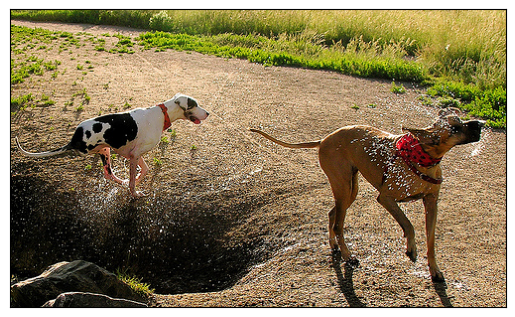


the man is on a black and white bike .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 5ms/step
Max prediction: 0.21201721
Image: 3517023411_a8fbd15230.jpg


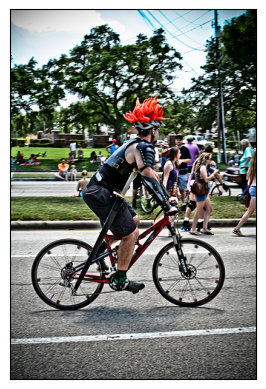


the tennis player in the blue shirt is holding his racquet up in the air .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 3ms/step
Max prediction: 0.02236437
Image: 1232148178_4f45cc3284.jpg


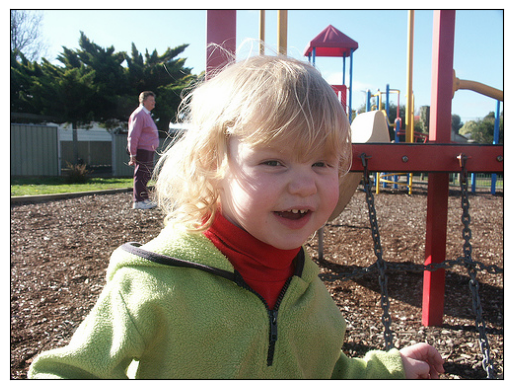


a watercraft speeds through the water .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 3ms/step
Max prediction: 0.04563602
Image: 3514297698_0512623955.jpg


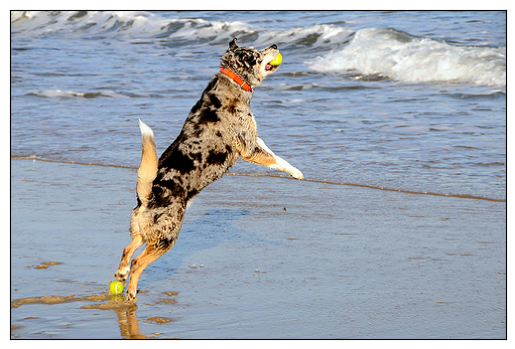


a man playing tennis looks very happy .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 3ms/step
Max prediction: 0.17545028
Image: 2670637584_d96efb8afa.jpg


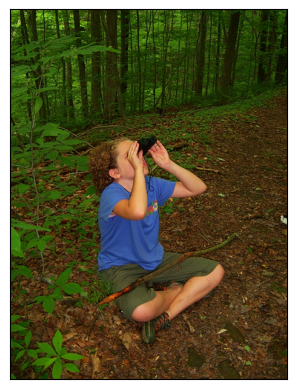


a man with glasses wearing all black sits on grass surrounded by other people .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 6ms/step
Max prediction: 0.07899797
Image: 2670637584_d96efb8afa.jpg


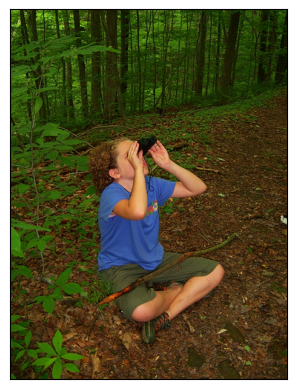


two men are standing under what looks to be a giant robot .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 5ms/step
Max prediction: 0.03046035
Image: 782401952_5bc5d3413a.jpg


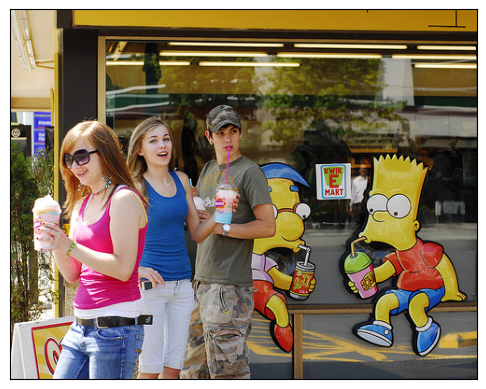


a man , seen from the back , with his head turned to the side wearing a backpack
test_df.shape: (100, 5)
4/4 [==============================] - 0s 8ms/step
Max prediction: 0.17023893
Image: 424307754_1e2f44d265.jpg


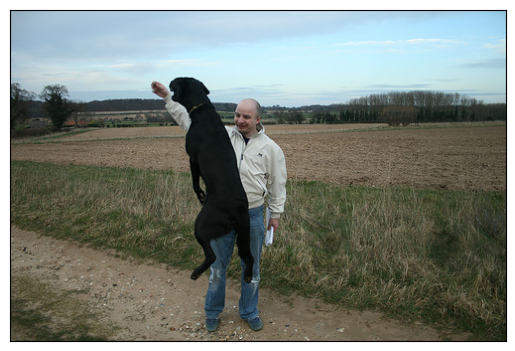


man in field with a black dog jumping at his raised arm .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 5ms/step
Max prediction: 0.27686355
Image: 3386953179_84c2d7922f.jpg


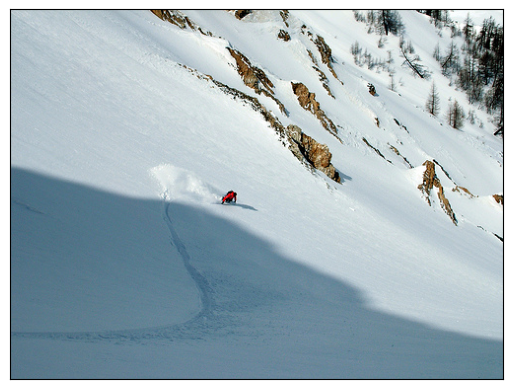


a man feeding a horse wearing a blue strapped blanket .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 3ms/step
Max prediction: 0.04325267
Image: 424307754_1e2f44d265.jpg


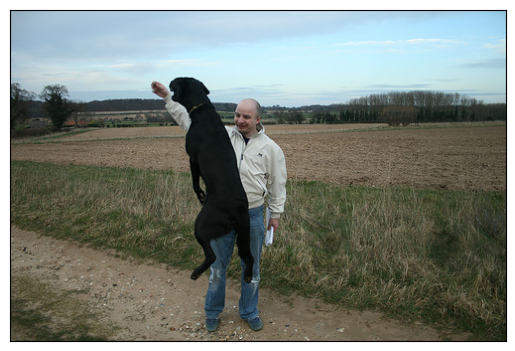

In [179]:
test_model()

## Вывод по проекту
### Постановка задачи
Заказчик проекта - фотохостинг "Со смыслом". Для нужд бизнеса необходимо разработать MWP модели, которая будет определять соответствие картинки текстовому описанию и выводить картинку по запросу. 

Кроме того, необходимо учесть юридические ограничения, запрещающие без разрешения родителей или законных представителей предоставлять любую информацию, содержащую описание, изображение или запись голоса детей. 

Изображения и описания, попадающие под ограничения, необходимо исключить из обучающего датасета, а при тесте работы модели на соответствующие описания изображений не показывать, а показывать дисклеймер. 

### Импорт библиотек и данных
Проект выполнен во фреймворке TensorFlow в среде разработки Google Colab. 

Исходные материалы размещены на личном google drive исполнителя.

### Предобработка данных
В ходе предобработки данных датасеты были проверены на наличие пропусков, дубликатов, распределение данных. Исходные материалы признаны достаточными для выполнения задания. 

Датасеты были объединены, очищены от нежелательного контента. Изображения и текстовые описания были преобразованы в вектора. 

В результате получилось два обучающих датасета, отличающихся методом кодирования текстов - в одном тексты превращены в токены, в другом в эмбеддинги. Дальнейшие эксперименты показали, что разница при обучении отсутствует, для обучения лучшей модели был выбран датасет с эмбеддингами.

Целевой признак - колонка 'final_yes_share', содержащая число от нуля до единицы. Оно означает степень соответствия картинки описанию.

### Обучение моделей
На датасетах были обучены модели двух типов: линейная регрессия (обычная и lasso) и нейронные сети двух конфигураций (с тремя и с четырьмя полносвязными слоями). Модели были обучены на кросс-валидации, линейные - на полном датасете, нейронные сети - на малом датасете из 1000 записей. 

Для оптимизации была выбрана метрика RMSE. Результат обучения на датасете с эмбеддингами следующий:




In [180]:
display(result)

models  rmse_train  rmse_valid
0      dummy    0.232621    0.231046
1         lr    0.214975    0.227874
2      lasso    0.232621    0.231046
3   first_nn    0.220289    0.218076
4  second_nn    0.180113    0.211731

### Выбор лучшей модели и ее обучение

По результатам сравнения лучшей признана модель нейронной сети с четырьмя полносвязными слоями - SecondNN. Она была обучена на полном датасете с эмбеддингами в течение 405 эпох.

In [181]:
model.summary()

Model: "second_nn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             multiple                  1262016   
                                                                 
 batch_normalization_3 (Batc  multiple                 1792      
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   multiple                  0         
                                                                 
 dropout_79 (Dropout)        multiple                  0         
                                                                 
 dense_8 (Dense)             multiple                  89800     
                                                                 
 batch_normalization_4 (Batc  multiple                 800       
 hNormalization)                                       

### Результат
Результат обучения выглядит довольно слабо. 

Модель научилась неплохо определять черное, мячи и собак. 

Кроме того, модель, кажется, получила некоторое представление о числах (например, на запрос 'two women ...' показывает собак, но двух) и цветах, но в основном применительно к собакам. 

Также она имеет некоторое представление о поверхностях: 'ice, water, rocks, mountains, dust, clouds, mud' ведут на картинки с поверхностями, не всегда правильными, но явно имеющими отношение к запросу.  

При этом модель посредственно отличает мужчин и женщин, и все, что связано с людьми.

Определенная корреляция между запросом и картинкой есть, но говорить о том, что картинка в основном соответствует запросу, нельзя. Есть частичное соответствие, и обычно модель показывает собак. 

Ожидаемо, в некоторых случаях модель выдает в качестве результата картинки с детьми, т.к. тестовый и обучающий датасеты от них не очищались, исключались только запросы с блок-словами и соответствующие им картинки. Это значит, что не все картинки с детьми были исключены из тренировочного датасета, и модель не имеет представления о детях.

Степень уверенности модели в предсказаниях низкая: степень соответствия картинки описанию редко оценивается числом выше 0.15. 

Протестировать модель можно, запустив этот код:

a young boy is holding a playstation controller over his head .
Sorry, this content violates the rules of your country! Try something else, please
No test_df

a little white dog in running on the sidewalk .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 5ms/step
Max prediction: 0.3508309
Image: 3154152744_4e93ec8a62.jpg


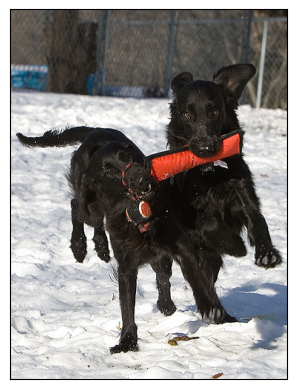


two men standing near a metal structure in from of a brick wall .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 4ms/step
Max prediction: 0.21945794
Image: 2399551242_c62a46dd5f.jpg


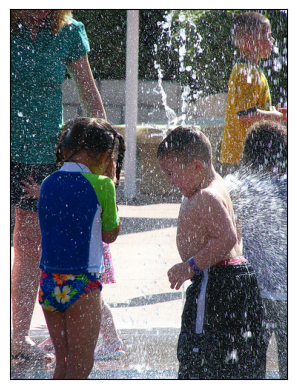


a dog is catching a yellow tennis ball on the beach .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 5ms/step
Max prediction: 0.2866144
Image: 3514297698_0512623955.jpg


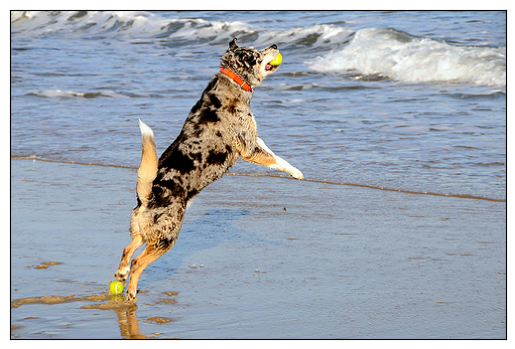


a young girl in blue hat and coat is riding a tricycle .
Sorry, this content violates the rules of your country! Try something else, please
No test_df

a sad looking dog sitting next to shrubs .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 3ms/step
Max prediction: 0.4289257
Image: 3466891862_9afde75568.jpg


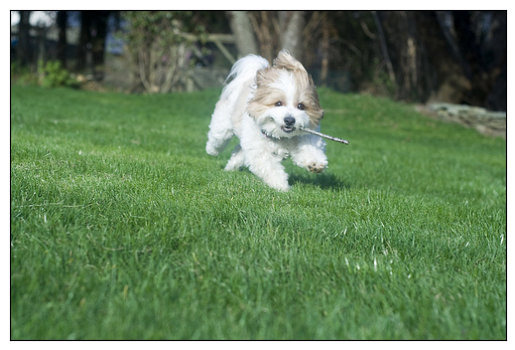


a black and white dog with a chunk of snow it its mouth while walking on a snowy surface .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 7ms/step
Max prediction: 0.13828374
Image: 424307754_1e2f44d265.jpg


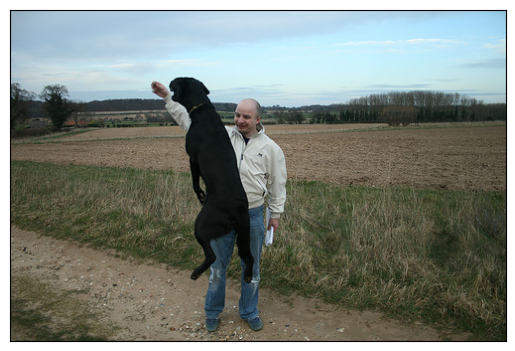


a woman wearing a red coat begins to take a picture .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 5ms/step
Max prediction: 0.034247715
Image: 3459871361_92d1ecda36.jpg


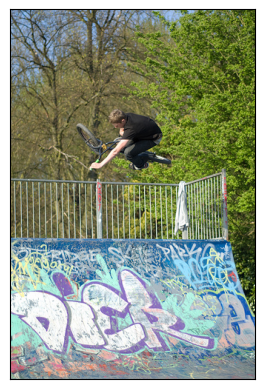


a tennis player wearing a blue shirt raises his hands and smiles .
test_df.shape: (100, 5)
4/4 [==============================] - 0s 7ms/step
Max prediction: 0.040950242
Image: 3091962081_194f2f3bd4.jpg


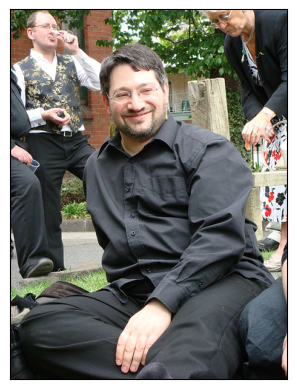


a little girl buried in the sand .
Sorry, this content violates the rules of your country! Try something else, please
No test_df



In [182]:
test_model()

### Предложения по дальнейшему развитию проекта
Эксперимент кажется частичным успехом, но модель требует серьезного дообучения. 

Можно изменить предобработку текущего датасета: сгенерировать больше соответствующих друг другу пар, например, распарсив query_id; не убирать картинки, которым не соответствуют описания, попадающие под юридические ограничения. Можно найти более обширный датасет.

Можно учесть дисбаланс классов при обучении моделей, это может дать хороший результат.

Можно попробовать обучить модель в течение большего количества эпох, но сейчас она вылетает по колбэку early_stopping, так как метрика на валидации не улучшается.

В конце концов, можно постараться найти модель, обученную профессиональным коллективом на огромном датасете и выполняющую аналогичную задачу, а затем дообучить на датасете заказчика.